https://www.kaggle.com/competitions/ieee-fraud-detection

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Redução de dimensionalidade
    * Seleção de atributos com teste do Qui-Quadrado (top 50 e top 100)
    * Seleção de atributos com teste ANOVA (top 50 e top 100)
* Separação entre base de treino e de teste, a partir da base de treino
* Balanceamento de classes
    * Undersample
        * Near Miss
    * Oversample
        * Resample
        * ROS
        * SMOTE
        * Borderline SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho, com validação cruzada (10 folds)
    * Algoritmos utilizados
        * Extra Trees
        * Random Forest
        * Decision Tree
        * CatBoost
        * Gradient Boost Classifier
        * AdaBoost
        * Logistic Regression
        * KNN
        * Naive Bayes
    * Métricas de desempenho
        * F1-score positivo
        * F1-score negativo
        * Wall time

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int64,0,2,0,0,0,0.220000000000000
2,TransactionDT,int64,0,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
4,ProductCD,object,0,5,W,W,W,1.280000000000000
5,card1,int64,0,13553,13926,2755,4663,9.970000000000001
6,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
7,card3,float64,1565,114,150.0,150.0,150.0,0.680000000000000
8,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
9,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000


In [10]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,506691,3663549,3663550,3663551,18.949999999999999
1,TransactionDT,int64,0,494686,18403224,18403263,18403310,18.899999999999999
2,TransactionAmt,float64,0,14119,31.949999999999999,49.0,171.0,8.080000000000000
3,ProductCD,object,0,5,W,W,W,1.370000000000000
4,card1,int64,0,13244,10409,4272,4476,9.949999999999999
5,card2,float64,8654,497,111.0,111.0,574.0,6.280000000000000
6,card3,float64,3002,115,150.0,150.0,150.0,0.810000000000000
7,card4,object,3086,4,visa,visa,visa,1.050000000000000
8,card5,float64,4547,102,226.0,226.0,226.0,2.630000000000000
9,card6,object,3007,3,debit,debit,debit,0.790000000000000


In [11]:
# checando todas as colunas dos conjuntos de dado de treino e teste
for i in list(train):
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

In [12]:
for i in list(test):
    print("'" + i + "'" + ", ")

'TransactionID', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V65', 
'V66', 

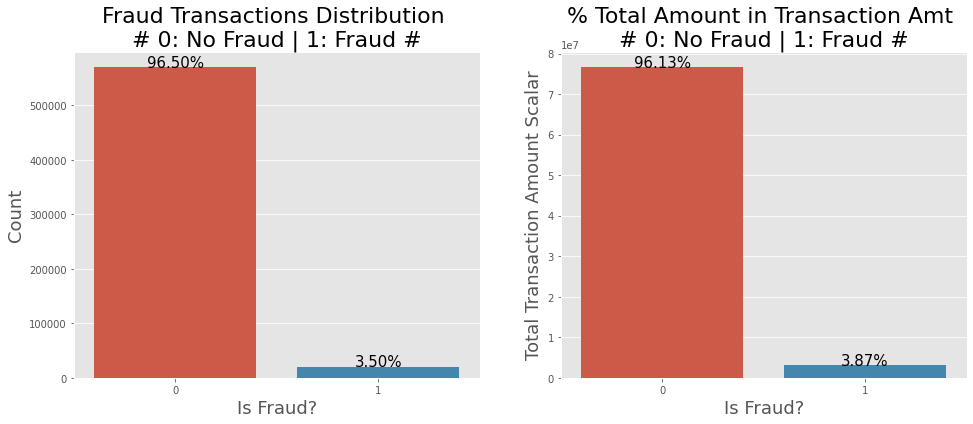

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [17]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [18]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [19]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [20]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [21]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

V324: 86.05496664070174%
V325: 86.05496664070174%
V326: 86.05496664070174%
V327: 86.05496664070174%
V328: 86.05496664070174%
V329: 86.05496664070174%
V330: 86.05496664070174%
V331: 86.05496664070174%
V332: 86.05496664070174%
V333: 86.05496664070174%
V334: 86.05496664070174%
V335: 86.05496664070174%
V336: 86.05496664070174%
V337: 86.05496664070174%
V338: 86.05496664070174%
V339: 86.05496664070174%
id_01: 75.5760829071697%
id_02: 76.14522301622245%
id_03: 88.76892335828225%
id_04: 88.76892335828225%
id_05: 76.82375452975243%
id_06: 76.82375452975243%
id_07: 99.12707013919463%
id_08: 99.12707013919463%
id_09: 87.31229044603245%
id_10: 87.31229044603245%
id_11: 76.12727334304196%
id_12: 75.5760829071697%
id_13: 78.44007179869273%
id_14: 86.4456260371863%
id_15: 76.12608798726589%
id_16: 78.09801198902699%
id_17: 76.39973583499848%
id_18: 92.36072069631184%
id_19: 76.40837199850984%
id_20: 76.41802418125783%
id_21: 99.12639279303689%
id_22: 99.1246994276425%
id_23: 99.1246994276425%
id_24: 

In [22]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [23]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [24]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [26]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [27]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [29]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [30]:
train.shape

(590540, 92)

In [31]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [32]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [33]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [34]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [35]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,isFraud,int64,0,2,0,0,0,0.220000000000000
1,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
2,ProductCD,object,0,5,W,W,W,1.280000000000000
3,card1,int64,0,13553,13926,2755,4663,9.970000000000001
4,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
5,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
6,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000
7,addr1,float64,65706,332,315.0,325.0,330.0,5.060000000000000
8,dist1,float64,352271,2651,19.0,NaN,287.0,6.340000000000000
9,P_emaildomain,object,94456,59,NaN,gmail.com,outlook.com,2.680000000000000


In [36]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [37]:
train = replace_missing_values(train)

In [38]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [39]:
test = replace_missing_values(test)

In [40]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [41]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [42]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [43]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [44]:
# realizando a transformação usando LabelEncoder
#le = LabelEncoder()
#for col in object_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [45]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


,Name,dtypes


In [46]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


,Name,dtypes


In [47]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [48]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [49]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [50]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [51]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [52]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [53]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [54]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML

In [55]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [56]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train = train_split.drop('isFraud',axis = 1)
y_train = train_split['isFraud'].astype('uint8')

X_test = test_split.drop('isFraud', axis = 1)
y_test = test_split['isFraud'].astype('uint8')

In [57]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    113975
1      4133
Name: count, dtype: int64


In [58]:
# combinando as classes minoritária com a majoritária subamostrada
test_split = pd.concat([X_test, y_test], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_split.isFraud.value_counts()

isFraud
0    113975
1      4133
Name: count, dtype: int64

# Balanceamento de Classes

## Undersample

### Undersampling com Near Miss

In [59]:
from imblearn.under_sampling import NearMiss

In [60]:
nm = NearMiss()

In [61]:
%%time
X_train_undersample_with_near_miss, y_train_undersample_with_near_miss = nm.fit_resample(X_train, y_train)

CPU times: user 2min, sys: 682 ms, total: 2min
Wall time: 11 s


In [62]:
# combinando as classes minoritária com a majoritária subamostrada
train_undersample_with_near_miss = pd.concat([X_train_undersample_with_near_miss, y_train_undersample_with_near_miss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_undersample_with_near_miss.isFraud.value_counts()

isFraud
0    16530
1    16530
Name: count, dtype: int64

## Oversample

### Resample

In [63]:
from sklearn.utils import resample

In [64]:
%%time
train_split_not_fraud = train_split[train_split.isFraud == 0]
train_split_fraud = train_split[train_split.isFraud == 1]

CPU times: user 121 ms, sys: 23.9 ms, total: 145 ms
Wall time: 144 ms


In [65]:
%%time
train_split_fraud_upsampled = resample(train_split_fraud, 
                           replace = True, # sample with replacement
                           n_samples = len(train_split_not_fraud), # match number in majority class
                           random_state = 27)

CPU times: user 81 ms, sys: 16 ms, total: 97 ms
Wall time: 95.9 ms


In [66]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_resample = pd.concat([train_split_not_fraud, train_split_fraud_upsampled])

# contando as classes minoritária e majoritária
train_oversample_with_resample.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [67]:
X_train_oversample_with_resample = train_oversample_with_resample.drop('isFraud',axis = 1)
y_train_oversample_with_resample = train_oversample_with_resample['isFraud'].astype('uint8')

### Random over-sampling

In [68]:
from imblearn.over_sampling import RandomOverSampler

In [69]:
ros = RandomOverSampler(random_state=42)

In [70]:
%%time
X_train_oversample_with_ros, y_train_oversample_with_ros = ros.fit_resample(X_train, y_train)

CPU times: user 1.75 s, sys: 304 ms, total: 2.05 s
Wall time: 2.05 s


In [71]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_ros = pd.concat([X_train_oversample_with_ros, y_train_oversample_with_ros], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_ros.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com SMOTE

In [72]:
from imblearn.over_sampling import SMOTE

In [73]:
smote = SMOTE(random_state=42)

In [74]:
%%time
X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)

CPU times: user 6.09 s, sys: 515 ms, total: 6.61 s
Wall time: 2.54 s


In [75]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com Borderline-SMOTE

In [76]:
from imblearn.over_sampling import BorderlineSMOTE

In [77]:
smote = BorderlineSMOTE(random_state=42)

In [78]:
%%time
X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = smote.fit_resample(X_train, y_train)

CPU times: user 2min 3s, sys: 538 ms, total: 2min 3s
Wall time: 13.2 s


In [79]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_borderline_smote = pd.concat([X_train_oversample_with_borderline_smote, \
                                                    y_train_oversample_with_borderline_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_borderline_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com AdaSyn

In [80]:
from imblearn.over_sampling import ADASYN

In [81]:
adasyn = ADASYN(random_state=42)

In [82]:
%%time
X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

CPU times: user 2min 4s, sys: 495 ms, total: 2min 4s
Wall time: 13.3 s


In [83]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()

isFraud
1    456567
0    455902
Name: count, dtype: int64

In [84]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.2e+02 s


# Redução de Dimensionalidade

## Seleção de Atributos com Teste do Qui-Quadrado

In [85]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Undersampling com Near Miss

In [86]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_50_chi2 = new_50_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_undersample_with_near_miss.iloc[:, cols]

In [87]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_chi2 = new_100_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_near_miss.iloc[:, cols]

In [88]:
undersample_with_near_miss_cols_50_chi2 = features_df_new_50_chi2.columns
undersample_with_near_miss_cols_100_chi2 = features_df_new_100_chi2.columns

In [89]:
undersample_with_near_miss_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V35', 'V36', 'V50', 'V53', 'V54', 'V75',
       'V76', 'V84', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V283', 'V285', 'V307', 'V308', 'V310', 'ProductCD_C', 'ProductCD_W',
       'P_emaildomain_hotmail.com', 'M4_M0', 'M4_M2', 'M5_T', 'M6_T'],
      dtype='object')

In [90]:
undersample_with_near_miss_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Hours', '_Days',
       'ProductCD_C', 'ProductCD_H', 'ProductCD_S', 'ProductCD_W',
       'card4_american express', 'card4_discover', 'card4_mastercard',
       'P_emaildomain_aim.com', 'P_emaildomain_anonymous.com',
       'P_emaildomain_aol.com', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_hotmail.es', 'P_emaildomain_live.com.mx',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.es',
       'P_emai

### Oversample com Resample

In [91]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_50_chi2 = new_50_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_resample.iloc[:, cols]

In [92]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_chi2 = new_100_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_resample.iloc[:, cols]

In [93]:
oversample_with_resample_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_resample_cols_100_chi2 = features_df_new_100_chi2.columns

In [94]:
oversample_with_resample_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [95]:
oversample_with_resample_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V5', 'V10', 'V11', 'V12', 'V13', 'V29',
       'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130',
       'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays',
       '_Hours', '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'P_emaildomain_aim.com',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_emaild

### Random over-sampling

In [96]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_50_chi2 = new_50_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_ros.iloc[:, cols]

In [97]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_chi2 = new_100_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_ros.iloc[:, cols]

In [98]:
oversample_with_ros_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_ros_cols_100_chi2 = features_df_new_100_chi2.columns

In [99]:
oversample_with_ros_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [100]:
oversample_with_ros_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V3', 'V5', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127',
       'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310',
       '_Weekdays', '_Hours', '_Days', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_S', 'ProductCD_W', 'card4_discover', 'P_emaildomain_aim.com',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_

### Oversampling com SMOTE

In [101]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [102]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [103]:
oversample_with_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [104]:
oversample_with_smote_cols_50_chi2

Index(['card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13',
       'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V29', 'V30',
       'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V69',
       'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96',
       'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310', 'ProductCD_C',
       'M4_M2'],
      dtype='object')

In [105]:
oversample_with_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V282',
       'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours', '_Days',
       'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_att.net',
       'P_emaildomain_comcast.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       '

### Oversampling com Borderline-SMOTE

In [106]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [107]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [108]:
oversample_with_borderline_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_borderline_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [109]:
oversample_with_borderline_smote_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V48', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [110]:
oversample_with_borderline_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_hotmail.es', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
    

### Oversampling com AdaSyn

In [111]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_chi2 = new_50_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [112]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_chi2 = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [113]:
oversample_with_adasyn_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_adasyn_cols_100_chi2 = features_df_new_100_chi2.columns

In [114]:
oversample_with_adasyn_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V50', 'V51',
       'V52', 'V80', 'V81', 'V84', 'V85', 'V91', 'V92', 'V93', 'V96', 'V99',
       'V127', 'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [115]:
oversample_with_adasyn_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_american express', 'card4_discover',
       'card4_mastercard', 'card4_visa', 'P_emaildomain_aim.com',
       'P_emaildomain_att.net', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_icloud.com', 'P_emaildomain_live.com.mx',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.com',
  

## Seleção de Features com Teste ANOVA

In [116]:
from sklearn.feature_selection import f_classif

### Undersampling com Near Miss

In [117]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_50_anova = new_50_anova.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_undersample_with_near_miss.iloc[:, cols]

In [118]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_anova = new_100_anova.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_near_miss.iloc[:, cols]

In [119]:
undersample_with_near_miss_cols_50_anova = features_df_new_50_anova.columns
undersample_with_near_miss_cols_100_anova = features_df_new_100_anova.columns

In [120]:
undersample_with_near_miss_cols_50_anova

Index(['TransactionAmt', 'D1', 'D2', 'D4', 'D10', 'D15', 'V1', 'V10', 'V11',
       'V12', 'V13', 'V35', 'V36', 'V39', 'V42', 'V43', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V84',
       'V85', 'V92', 'V93', 'V96', 'V99', 'V127', 'V283', 'V285', 'V310',
       'ProductCD_C', 'ProductCD_W', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'M3_F', 'M3_T', 'M4_M0', 'M4_M2', 'M5_F',
       'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

In [121]:
undersample_with_near_miss_cols_100_anova

Index(['TransactionAmt', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V1', 'V3', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29',
       'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130',
       'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_S', 'ProductCD_W',
       'card4_american express', 'card4_discover', 'card4_mastercard',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_yahoo.com',
       'P_emaildomain_yahoo.com.mx', 'M2_F', 'M2_T', 'M3_F', 'M3_T', 'M4_M0',
       'M4_M1', 'M4_M2', 'M5_F', 'M5_T', 'M6_F'

### Oversample com Resample

In [122]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_50_anova = new_50_anova.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_resample.iloc[:, cols]

In [123]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_anova = new_100_anova.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_resample.iloc[:, cols]

In [124]:
oversample_with_resample_cols_50_anova = features_df_new_50_anova.columns
oversample_with_resample_cols_100_anova = features_df_new_100_anova.columns

In [125]:
oversample_with_resample_cols_50_anova

Index(['C5', 'C9', 'D1', 'D2', 'D3', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11',
       'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70', 'V75', 'V76',
       'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283',
       'ProductCD_C', 'ProductCD_W', 'P_emaildomain_yahoo.com', 'M4_M0',
       'M4_M2', 'M6_F', 'M6_T', 'M8_F', 'M8_T'],
      dtype='object')

In [126]:
oversample_with_resample_cols_100_anova

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
       'V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V282',
       'V283', 'V285', 'V307', 'V310', '_Weekdays', '_Hours', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'P_emaildomain_aim.com', 'P_emaildomain_anonymous.com',
       'P_emaildomain_aol.com', 'P_emaildomain_att.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_mail.com', 'P_emaildomain_msn.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       'P_emaildomain_protonmail.com', 'P_emaildomain_rocketmail.com',
       'P_emai

### Random over-sampling

In [127]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_50_anova = new_50_anova.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_ros.iloc[:, cols]

In [128]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_anova = new_100_anova.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_ros.iloc[:, cols]

In [129]:
oversample_with_ros_cols_50_anova = features_df_new_50_anova.columns
oversample_with_ros_cols_100_anova = features_df_new_100_anova.columns

In [130]:
oversample_with_ros_cols_50_anova

Index(['C5', 'C9', 'D1', 'D2', 'D3', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11',
       'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70', 'V75', 'V76',
       'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283',
       'ProductCD_C', 'ProductCD_W', 'P_emaildomain_yahoo.com', 'M4_M0',
       'M4_M2', 'M6_F', 'M6_T', 'M8_F', 'M8_T'],
      dtype='object')

In [131]:
oversample_with_ros_cols_100_anova

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
       'V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V282',
       'V283', 'V285', 'V307', 'V310', '_Weekdays', '_Hours', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_emaildomain_rocketmail.com', 'P_emaildomain_sbcglobal.net',
       '

### Oversampling com SMOTE

In [132]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_anova = new_50_anova.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_smote.iloc[:, cols]

In [133]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_anova = new_100_anova.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_smote.iloc[:, cols]

In [134]:
oversample_with_smote_cols_50_anova = features_df_new_50_anova.columns
oversample_with_smote_cols_100_anova = features_df_new_100_anova.columns

In [135]:
oversample_with_smote_cols_50_anova

Index(['D1', 'D2', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_W', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'M3_T', 'M4_M0', 'M4_M2', 'M6_F', 'M6_T',
       'M7_F', 'M8_F'],
      dtype='object')

In [136]:
oversample_with_smote_cols_100_anova

Index(['card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V2', 'V3', 'V5',
       'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36',
       'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53',
       'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90',
       'V91', 'V92', 'V93', 'V96', 'V99', 'V282', 'V283', 'V285', 'V307',
       'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_american express',
       'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_att.net',
       'P_emaildomain_comcast.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       'P_emaildomain_proton

### Oversampling com Borderline-SMOTE

In [137]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_anova = new_50_anova.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [138]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_anova = new_100_anova.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [139]:
oversample_with_borderline_smote_cols_50_anova = features_df_new_50_anova.columns
oversample_with_borderline_smote_cols_100_anova = features_df_new_100_anova.columns

In [140]:
oversample_with_borderline_smote_cols_50_anova

Index(['C9', 'D1', 'D2', 'D3', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12',
       'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48',
       'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70', 'V75', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283', 'ProductCD_C',
       'ProductCD_W', 'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'M3_T', 'M4_M0', 'M4_M2', 'M6_F', 'M6_T', 'M7_F', 'M8_F'],
      dtype='object')

In [141]:
oversample_with_borderline_smote_cols_100_anova

Index(['TransactionAmt', 'card1', 'card5', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11',
       'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V2', 'V3',
       'V5', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30', 'V35',
       'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52',
       'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84', 'V85',
       'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V282', 'V283', 'V285',
       'V307', 'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'card4_mastercard', 'card4_visa', 'P_emaildomain_aim.com',
       'P_emaildomain_aol.com', 'P_emaildomain_att.net',
       'P_emaildomain_comcast.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_hotmail.es',
       'P_emaildomain_icloud.com', 'P_emaildomain_live.com.mx',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.com',
       'P_emai

### Oversampling com AdaSyn

In [142]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_anova = new_50_anova.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_adasyn.iloc[:, cols]

In [143]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_anova = new_100_anova.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_adasyn.iloc[:, cols]

In [144]:
oversample_with_adasyn_cols_50_anova = features_df_new_50_anova.columns
oversample_with_adasyn_cols_100_anova = features_df_new_100_anova.columns

In [145]:
oversample_with_adasyn_cols_50_anova

Index(['C9', 'D1', 'D2', 'D4', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12',
       'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48',
       'V49', 'V50', 'V51', 'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85',
       'V90', 'V91', 'V92', 'V93', 'V282', 'V283', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_R', 'ProductCD_W', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'M3_T', 'M4_M2', 'M5_F', 'M6_F', 'M7_F',
       'M8_F', 'M9_T'],
      dtype='object')

In [146]:
oversample_with_adasyn_cols_100_anova

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
       'V2', 'V3', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V130', 'V282', 'V283',
       'V285', 'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_american express',
       'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_att.net',
       'P_emaildomain_comcast.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       'P_

In [147]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.6e+02 s


# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [148]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [149]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [150]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [151]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

## Validação Cruzada para Undersampling com Near Miss

### 50-Chi Square

In [152]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06921691773903113
F1-Score Negativo (Teste): 0.13406771212133595
F1-Score Positivo Médio (Validação Cruzada): 0.5087068639215157
F1-Score Negativo Médio (Validação Cruzada): 0.9871098197268635
CPU times: user 3min 12s, sys: 7.48 ms, total: 3min 12s
Wall time: 3min 12s


In [153]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06994503045609865
F1-Score Negativo (Teste): 0.30571308160383287
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 45.6 s, sys: 6.57 ms, total: 45.6 s
Wall time: 45.6 s


In [154]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06993585020934036
F1-Score Negativo (Teste): 0.17128584466112687
F1-Score Positivo Médio (Validação Cruzada): 0.4199560021647321
F1-Score Negativo Médio (Validação Cruzada): 0.9774921827647425
CPU times: user 33.9 s, sys: 0 ns, total: 33.9 s
Wall time: 33.9 s


In [155]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.5486660	total: 55.6ms	remaining: 222ms
1:	learn: 0.4499591	total: 59.4ms	remaining: 89.1ms
2:	learn: 0.3898432	total: 63.5ms	remaining: 42.3ms
3:	learn: 0.3384661	total: 67.4ms	remaining: 16.9ms
4:	learn: 0.3036133	total: 71.4ms	remaining: 0us
0:	learn: 0.5412350	total: 7.29ms	remaining: 29.2ms
1:	learn: 0.4305049	total: 13.9ms	remaining: 20.8ms
2:	learn: 0.3549745	total: 20.5ms	remaining: 13.6ms
3:	learn: 0.2966035	total: 26.9ms	remaining: 6.72ms
4:	learn: 0.2518184	total: 34ms	remaining: 0us
0:	learn: 0.5408677	total: 7.93ms	remaining: 31.7ms
1:	learn: 0.4299505	total: 15ms	remaining: 22.5ms
2:	learn: 0.3544987	total: 21.7ms	remaining: 14.5ms
3:	learn: 0.2938726	total: 28.4ms	remaining: 7.09ms
4:	learn: 0.2496464	total: 35.4ms	remaining: 0us
0:	learn: 0.5408187	total: 8.59ms	remaining: 34.4ms
1:	learn: 0.4298406	total: 15.9ms	remaining: 23.8ms
2:	learn: 0.3551051	total: 24ms	remaining: 16ms
3:	learn: 0.2964751	total: 30.6ms	remaining: 7.64ms
4:	learn: 0.2516459	total: 37.

In [156]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07319619628093345
F1-Score Negativo (Teste): 0.24144912585932152
F1-Score Positivo Médio (Validação Cruzada): 0.37373240072474795
F1-Score Negativo Médio (Validação Cruzada): 0.9854448828813899
CPU times: user 2min 46s, sys: 3.62 ms, total: 2min 46s
Wall time: 2min 46s


In [157]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07259080905174847
F1-Score Negativo (Teste): 0.24088872465240888
F1-Score Positivo Médio (Validação Cruzada): 0.3359914079830123
F1-Score Negativo Médio (Validação Cruzada): 0.984955386486013
CPU times: user 3min 25s, sys: 11.4 ms, total: 3min 25s
Wall time: 3min 25s


In [158]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.073947786796084
F1-Score Negativo (Teste): 0.3703203231679563
F1-Score Positivo Médio (Validação Cruzada): 0.0014446246524559777
F1-Score Negativo Médio (Validação Cruzada): 0.9821342383505549
CPU times: user 2min 25s, sys: 1min 36s, total: 4min 1s
Wall time: 20.2 s


In [159]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06707020721954668
F1-Score Negativo (Teste): 0.1420224134708373
F1-Score Positivo Médio (Validação Cruzada): 0.2660959871282388
F1-Score Negativo Médio (Validação Cruzada): 0.9817069083994772
CPU times: user 3min 48s, sys: 660 ms, total: 3min 49s
Wall time: 25.2 s


In [160]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06571277159512454
F1-Score Negativo (Teste): 0.31398259975771814
F1-Score Positivo Médio (Validação Cruzada): 0.1488887440315481
F1-Score Negativo Médio (Validação Cruzada): 0.8657345659181803
CPU times: user 1.48 s, sys: 6 µs, total: 1.48 s
Wall time: 1.48 s


### 100 Chi-Square

In [161]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07018481883476804
F1-Score Negativo (Teste): 0.1585186857852546
F1-Score Positivo Médio (Validação Cruzada): 0.5093490495163214
F1-Score Negativo Médio (Validação Cruzada): 0.9877550682952178
CPU times: user 4min 33s, sys: 219 ms, total: 4min 33s
Wall time: 4min 33s


In [162]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06840155760281127
F1-Score Negativo (Teste): 0.2508134365977728
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 47.1 s, sys: 11.7 ms, total: 47.1 s
Wall time: 47.1 s


In [163]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06960498587633951
F1-Score Negativo (Teste): 0.16798582208643079
F1-Score Positivo Médio (Validação Cruzada): 0.42420785881694584
F1-Score Negativo Médio (Validação Cruzada): 0.9774676205228113
CPU times: user 54 s, sys: 0 ns, total: 54 s
Wall time: 54 s


In [164]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.5495964	total: 21.3ms	remaining: 85.3ms
1:	learn: 0.4584056	total: 36.3ms	remaining: 54.4ms
2:	learn: 0.3896532	total: 44.5ms	remaining: 29.6ms
3:	learn: 0.3436230	total: 50.9ms	remaining: 12.7ms
4:	learn: 0.3087937	total: 56.2ms	remaining: 0us
0:	learn: 0.5489121	total: 13ms	remaining: 52.1ms
1:	learn: 0.4308472	total: 24.3ms	remaining: 36.4ms
2:	learn: 0.3494382	total: 33.4ms	remaining: 22.3ms
3:	learn: 0.2900106	total: 41.2ms	remaining: 10.3ms
4:	learn: 0.2454209	total: 49.3ms	remaining: 0us
0:	learn: 0.5488396	total: 7.24ms	remaining: 29ms
1:	learn: 0.4309777	total: 14.7ms	remaining: 22ms
2:	learn: 0.3495525	total: 22.6ms	remaining: 15.1ms
3:	learn: 0.2888092	total: 30.6ms	remaining: 7.64ms
4:	learn: 0.2445039	total: 38.5ms	remaining: 0us
0:	learn: 0.5486576	total: 8.71ms	remaining: 34.9ms
1:	learn: 0.4309470	total: 17.5ms	remaining: 26.2ms
2:	learn: 0.3494654	total: 26.6ms	remaining: 17.7ms
3:	learn: 0.2900487	total: 34.8ms	remaining: 8.69ms
4:	learn: 0.2453944	total: 

In [165]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07229005291103693
F1-Score Negativo (Teste): 0.2246866184321985
F1-Score Positivo Médio (Validação Cruzada): 0.3165131645663819
F1-Score Negativo Médio (Validação Cruzada): 0.9845479203800626
CPU times: user 3min 53s, sys: 11.9 ms, total: 3min 53s
Wall time: 3min 53s


In [166]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07141999649087165
F1-Score Negativo (Teste): 0.21396577735739916
F1-Score Positivo Médio (Validação Cruzada): 0.3337987953944918
F1-Score Negativo Médio (Validação Cruzada): 0.984881336982847
CPU times: user 4min 49s, sys: 27.8 ms, total: 4min 49s
Wall time: 4min 49s


In [167]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07342543809114811
F1-Score Negativo (Teste): 0.3714803367792817
F1-Score Positivo Médio (Validação Cruzada): 0.001443466172381835
F1-Score Negativo Médio (Validação Cruzada): 0.9821210798508722
CPU times: user 3min 45s, sys: 1min 52s, total: 5min 38s
Wall time: 28.4 s


In [168]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06656344025478156
F1-Score Negativo (Teste): 0.13423092615259077
F1-Score Positivo Médio (Validação Cruzada): 0.26592916269016026
F1-Score Negativo Médio (Validação Cruzada): 0.9815379805616594
CPU times: user 5min 49s, sys: 828 ms, total: 5min 50s
Wall time: 35.8 s


In [169]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06597160515767234
F1-Score Negativo (Teste): 0.29886607870747794
F1-Score Positivo Médio (Validação Cruzada): 0.1821497517375636
F1-Score Negativo Médio (Validação Cruzada): 0.9144493996980559
CPU times: user 2.5 s, sys: 340 ms, total: 2.84 s
Wall time: 2.84 s


### 50 Anova

In [170]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07139117789626756
F1-Score Negativo (Teste): 0.28016172425713554
F1-Score Positivo Médio (Validação Cruzada): 0.3554025015897069
F1-Score Negativo Médio (Validação Cruzada): 0.98318921246599
CPU times: user 2min 57s, sys: 400 ms, total: 2min 58s
Wall time: 2min 58s


In [171]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.05727995467181331
F1-Score Negativo (Teste): 0.1361165647158086
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 36.8 s, sys: 4.05 ms, total: 36.8 s
Wall time: 36.8 s


In [172]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07137034161490682
F1-Score Negativo (Teste): 0.28150717847059537
F1-Score Positivo Médio (Validação Cruzada): 0.29374093794604067
F1-Score Negativo Médio (Validação Cruzada): 0.9747292055525374
CPU times: user 19.1 s, sys: 3.72 ms, total: 19.1 s
Wall time: 19.1 s


In [173]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.5783648	total: 7.54ms	remaining: 30.2ms
1:	learn: 0.4969425	total: 11.2ms	remaining: 16.8ms
2:	learn: 0.4418138	total: 14.5ms	remaining: 9.67ms
3:	learn: 0.3983298	total: 18ms	remaining: 4.5ms
4:	learn: 0.3707627	total: 21.3ms	remaining: 0us
0:	learn: 0.5418784	total: 12.3ms	remaining: 49ms
1:	learn: 0.4345513	total: 20.8ms	remaining: 31.2ms
2:	learn: 0.3511753	total: 28ms	remaining: 18.7ms
3:	learn: 0.2944856	total: 34.1ms	remaining: 8.53ms
4:	learn: 0.2570887	total: 39.7ms	remaining: 0us
0:	learn: 0.5414593	total: 7.92ms	remaining: 31.7ms
1:	learn: 0.4341598	total: 15.6ms	remaining: 23.5ms
2:	learn: 0.3514502	total: 22.3ms	remaining: 14.9ms
3:	learn: 0.2960071	total: 30.7ms	remaining: 7.68ms
4:	learn: 0.2542453	total: 36.6ms	remaining: 0us
0:	learn: 0.5416621	total: 5.91ms	remaining: 23.6ms
1:	learn: 0.4343097	total: 11.6ms	remaining: 17.4ms
2:	learn: 0.3515797	total: 16.7ms	remaining: 11.1ms
3:	learn: 0.2960683	total: 23.1ms	remaining: 5.78ms
4:	learn: 0.2542647	total: 2

In [174]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06884798249266494
F1-Score Negativo (Teste): 0.27668584753093384
F1-Score Positivo Médio (Validação Cruzada): 0.10084491267621723
F1-Score Negativo Médio (Validação Cruzada): 0.9823007103788118
CPU times: user 1min 57s, sys: 436 µs, total: 1min 57s
Wall time: 1min 57s


In [175]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06780377648585019
F1-Score Negativo (Teste): 0.26592307284848393
F1-Score Positivo Médio (Validação Cruzada): 0.08701575175316636
F1-Score Negativo Médio (Validação Cruzada): 0.9824517407262621
CPU times: user 2min 32s, sys: 8.72 ms, total: 2min 32s
Wall time: 2min 32s


In [176]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06699391924994476
F1-Score Negativo (Teste): 0.26485615023047754
F1-Score Positivo Médio (Validação Cruzada): 0.0019150394756711612
F1-Score Negativo Médio (Validação Cruzada): 0.9820902163258912
CPU times: user 3min 32s, sys: 2min 19s, total: 5min 51s
Wall time: 29.5 s


In [177]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06798541187663522
F1-Score Negativo (Teste): 0.3049840368925151
F1-Score Positivo Médio (Validação Cruzada): 0.17434715212580426
F1-Score Negativo Médio (Validação Cruzada): 0.9801711517199877
CPU times: user 3min 50s, sys: 573 ms, total: 3min 51s
Wall time: 25.1 s


In [178]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06188542214152611
F1-Score Negativo (Teste): 0.2538705337802403
F1-Score Positivo Médio (Validação Cruzada): 0.18055077529467684
F1-Score Negativo Médio (Validação Cruzada): 0.9244482500912679
CPU times: user 1.44 s, sys: 94 µs, total: 1.44 s
Wall time: 1.44 s


### 100 Anova

In [179]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07120813495134141
F1-Score Negativo (Teste): 0.19264218281382303
F1-Score Positivo Médio (Validação Cruzada): 0.5073034260300331
F1-Score Negativo Médio (Validação Cruzada): 0.9876362138900857
CPU times: user 4min 32s, sys: 448 ms, total: 4min 32s
Wall time: 4min 32s


In [180]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07029828033776593
F1-Score Negativo (Teste): 0.3110272493421683
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 45.9 s, sys: 12 ms, total: 45.9 s
Wall time: 45.9 s


In [181]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07062398777136827
F1-Score Negativo (Teste): 0.1913229356345499
F1-Score Positivo Médio (Validação Cruzada): 0.42515133322865506
F1-Score Negativo Médio (Validação Cruzada): 0.9775985322305683
CPU times: user 50 s, sys: 392 µs, total: 50 s
Wall time: 50 s


In [182]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.5595316	total: 10ms	remaining: 40.1ms
1:	learn: 0.4578745	total: 14.5ms	remaining: 21.8ms
2:	learn: 0.3856302	total: 19ms	remaining: 12.6ms
3:	learn: 0.3371098	total: 23.3ms	remaining: 5.82ms
4:	learn: 0.3043331	total: 27.7ms	remaining: 0us
0:	learn: 0.5437291	total: 8.69ms	remaining: 34.8ms
1:	learn: 0.4323086	total: 17.5ms	remaining: 26.3ms
2:	learn: 0.3541452	total: 25.7ms	remaining: 17.1ms
3:	learn: 0.2954455	total: 33.2ms	remaining: 8.31ms
4:	learn: 0.2498223	total: 41.3ms	remaining: 0us
0:	learn: 0.5438121	total: 7.58ms	remaining: 30.3ms
1:	learn: 0.4324259	total: 15.6ms	remaining: 23.3ms
2:	learn: 0.3541319	total: 23.7ms	remaining: 15.8ms
3:	learn: 0.2952639	total: 31.2ms	remaining: 7.8ms
4:	learn: 0.2494709	total: 39.1ms	remaining: 0us
0:	learn: 0.5435427	total: 8.71ms	remaining: 34.9ms
1:	learn: 0.4321266	total: 17.9ms	remaining: 26.8ms
2:	learn: 0.3536510	total: 26ms	remaining: 17.3ms
3:	learn: 0.2949871	total: 33.5ms	remaining: 8.38ms
4:	learn: 0.2493270	total: 4

In [183]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07313504686570828
F1-Score Negativo (Teste): 0.24626367299942434
F1-Score Positivo Médio (Validação Cruzada): 0.2959972361429341
F1-Score Negativo Médio (Validação Cruzada): 0.9843414047363076
CPU times: user 3min 42s, sys: 2.37 ms, total: 3min 42s
Wall time: 3min 42s


In [184]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07277979157227005
F1-Score Negativo (Teste): 0.24603929996929688
F1-Score Positivo Médio (Validação Cruzada): 0.3342826353694373
F1-Score Negativo Médio (Validação Cruzada): 0.9848987739936538
CPU times: user 4min 41s, sys: 10.6 ms, total: 4min 41s
Wall time: 4min 41s


In [185]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07524543308065117
F1-Score Negativo (Teste): 0.3605676968464469
F1-Score Positivo Médio (Validação Cruzada): 0.019430652234275893
F1-Score Negativo Médio (Validação Cruzada): 0.9821941962341304
CPU times: user 4min 20s, sys: 2min 5s, total: 6min 25s
Wall time: 32.4 s


In [186]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06815798039712105
F1-Score Negativo (Teste): 0.17960515841426522
F1-Score Positivo Médio (Validação Cruzada): 0.25494949986687
F1-Score Negativo Médio (Validação Cruzada): 0.9816115427279295
CPU times: user 5min 51s, sys: 1.09 s, total: 5min 52s
Wall time: 35.9 s


In [187]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06479553107421608
F1-Score Negativo (Teste): 0.2799748242945558
F1-Score Positivo Médio (Validação Cruzada): 0.18132115684079153
F1-Score Negativo Médio (Validação Cruzada): 0.9115585216774045
CPU times: user 2.57 s, sys: 116 ms, total: 2.69 s
Wall time: 2.69 s


### Todas as colunas

In [188]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07047235280949184
F1-Score Negativo (Teste): 0.16649938574445364
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 5min 29s, sys: 75.2 ms, total: 5min 29s
Wall time: 5min 29s


In [189]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.0699179634475025
F1-Score Negativo (Teste): 0.297278416100599
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 43.5 s, sys: 3.94 ms, total: 43.5 s
Wall time: 43.5 s


In [190]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06991460674157304
F1-Score Negativo (Teste): 0.17199878366915802
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 9s, sys: 889 µs, total: 1min 9s
Wall time: 1min 9s


In [191]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.5543125	total: 20.3ms	remaining: 81.2ms
1:	learn: 0.4536557	total: 32.1ms	remaining: 48.1ms
2:	learn: 0.3951482	total: 39.7ms	remaining: 26.5ms
3:	learn: 0.3439968	total: 45.8ms	remaining: 11.4ms
4:	learn: 0.3077965	total: 51.1ms	remaining: 0us
0:	learn: 0.5336608	total: 12.7ms	remaining: 50.9ms
1:	learn: 0.4271318	total: 22.4ms	remaining: 33.6ms
2:	learn: 0.3416706	total: 31ms	remaining: 20.7ms
3:	learn: 0.2888256	total: 38.8ms	remaining: 9.7ms
4:	learn: 0.2438958	total: 47.7ms	remaining: 0us
0:	learn: 0.5331992	total: 9.1ms	remaining: 36.4ms
1:	learn: 0.4266171	total: 17.8ms	remaining: 26.7ms
2:	learn: 0.3413103	total: 26.3ms	remaining: 17.5ms
3:	learn: 0.2883925	total: 34.2ms	remaining: 8.54ms
4:	learn: 0.2434156	total: 42.8ms	remaining: 0us
0:	learn: 0.5334749	total: 8.5ms	remaining: 34ms
1:	learn: 0.4268605	total: 17.1ms	remaining: 25.7ms
2:	learn: 0.3408881	total: 25.4ms	remaining: 16.9ms
3:	learn: 0.2880311	total: 33.2ms	remaining: 8.31ms
4:	learn: 0.2431527	total: 4

In [192]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07288269036103925
F1-Score Negativo (Teste): 0.23631141718909238
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 4min 36s, sys: 2.16 ms, total: 4min 36s
Wall time: 4min 36s


In [193]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07171491382017697
F1-Score Negativo (Teste): 0.21457711365021806
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 6min 3s, sys: 463 ms, total: 6min 4s
Wall time: 6min 4s


In [194]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07357335395031031
F1-Score Negativo (Teste): 0.36889154602781454
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 6min 53s, sys: 1min 41s, total: 8min 34s
Wall time: 43.6 s


In [195]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06659687337796585
F1-Score Negativo (Teste): 0.1342178919108587
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 8min 50s, sys: 1.35 s, total: 8min 51s
Wall time: 51.9 s


In [196]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06565101614547758
F1-Score Negativo (Teste): 0.3018558104099943
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 3.86 s, sys: 432 ms, total: 4.29 s
Wall time: 4.29 s


In [197]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 4.6e+03 s


## Validação Cruzada para Oversample com Resample

### 50 Chi-Square

In [198]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5566951566951567
F1-Score Negativo (Teste): 0.9864221016073579
F1-Score Positivo Médio (Validação Cruzada): 0.5008251879358352
F1-Score Negativo Médio (Validação Cruzada): 0.986785297815574
CPU times: user 5min 25s, sys: 468 ms, total: 5min 26s
Wall time: 5min 26s


In [199]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1300681529398175
F1-Score Negativo (Teste): 0.754789064111052
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 11s, sys: 56.6 ms, total: 1min 11s
Wall time: 1min 11s


In [200]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.48991354466858794
F1-Score Negativo (Teste): 0.9805529552915738
F1-Score Positivo Médio (Validação Cruzada): 0.41650420427640167
F1-Score Negativo Médio (Validação Cruzada): 0.9776024462657826
CPU times: user 44.9 s, sys: 24.1 ms, total: 44.9 s
Wall time: 44.9 s


In [201]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6477980	total: 52.6ms	remaining: 210ms
1:	learn: 0.6137814	total: 109ms	remaining: 164ms
2:	learn: 0.5891716	total: 163ms	remaining: 109ms
3:	learn: 0.5664026	total: 216ms	remaining: 54ms
4:	learn: 0.5506657	total: 274ms	remaining: 0us
0:	learn: 0.5424156	total: 11.1ms	remaining: 44.5ms
1:	learn: 0.4303587	total: 20ms	remaining: 30ms
2:	learn: 0.3507923	total: 27.1ms	remaining: 18ms
3:	learn: 0.2955855	total: 33.3ms	remaining: 8.32ms
4:	learn: 0.2489660	total: 40.3ms	remaining: 0us
0:	learn: 0.5417738	total: 7.2ms	remaining: 28.8ms
1:	learn: 0.4297384	total: 15.2ms	remaining: 22.8ms
2:	learn: 0.3500519	total: 22.2ms	remaining: 14.8ms
3:	learn: 0.2950119	total: 28.7ms	remaining: 7.17ms
4:	learn: 0.2485401	total: 35.8ms	remaining: 0us
0:	learn: 0.5421319	total: 14.3ms	remaining: 57.3ms
1:	learn: 0.4300135	total: 24.7ms	remaining: 37.1ms
2:	learn: 0.3502803	total: 32.2ms	remaining: 21.5ms
3:	learn: 0.2951548	total: 38.6ms	remaining: 9.65ms
4:	learn: 0.2486279	total: 45.6ms	rem

In [202]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2287978479770257
F1-Score Negativo (Teste): 0.8983503188680783
F1-Score Positivo Médio (Validação Cruzada): 0.31784210358845866
F1-Score Negativo Médio (Validação Cruzada): 0.9845963229272048
CPU times: user 4min 17s, sys: 42.2 ms, total: 4min 17s
Wall time: 4min 17s


In [203]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22629682997118156
F1-Score Negativo (Teste): 0.8969662662624246
F1-Score Positivo Médio (Validação Cruzada): 0.33022774275151706
F1-Score Negativo Médio (Validação Cruzada): 0.9848742874732139
CPU times: user 5min 7s, sys: 2.31 s, total: 5min 10s
Wall time: 5min 10s


In [204]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09799014031095941
F1-Score Negativo (Teste): 0.6508036243841425
F1-Score Positivo Médio (Validação Cruzada): 0.0009626969416126043
F1-Score Negativo Médio (Validação Cruzada): 0.982116846168473
CPU times: user 3min 30s, sys: 2min 19s, total: 5min 49s
Wall time: 29.5 s


In [205]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3849985350131849
F1-Score Negativo (Teste): 0.9721343322550524
F1-Score Positivo Médio (Validação Cruzada): 0.25622316984815047
F1-Score Negativo Médio (Validação Cruzada): 0.9815974258574517
CPU times: user 18min 3s, sys: 1.05 s, total: 18min 4s
Wall time: 1min 37s


In [206]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1826204412426835
F1-Score Negativo (Teste): 0.9151706026933825
F1-Score Positivo Médio (Validação Cruzada): 0.18426833297525183
F1-Score Negativo Médio (Validação Cruzada): 0.9248217956073399
CPU times: user 1.85 s, sys: 144 ms, total: 1.99 s
Wall time: 1.99 s


### 100 Chi-Square

In [207]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.637373249637856
F1-Score Negativo (Teste): 0.9902044755937967
F1-Score Positivo Médio (Validação Cruzada): 0.49840362459466886
F1-Score Negativo Médio (Validação Cruzada): 0.9876061666909178
CPU times: user 7min 22s, sys: 337 ms, total: 7min 22s
Wall time: 7min 22s


In [208]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14182183075036234
F1-Score Negativo (Teste): 0.7988984746905226
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 13s, sys: 796 ms, total: 1min 13s
Wall time: 1min 13s


In [209]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5391721655668866
F1-Score Negativo (Teste): 0.983144711494157
F1-Score Positivo Médio (Validação Cruzada): 0.4278142475447792
F1-Score Negativo Médio (Validação Cruzada): 0.9777314579657853
CPU times: user 1min 18s, sys: 88.8 ms, total: 1min 18s
Wall time: 1min 18s


In [210]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6472685	total: 64.9ms	remaining: 260ms
1:	learn: 0.6129292	total: 126ms	remaining: 189ms
2:	learn: 0.5862976	total: 188ms	remaining: 126ms
3:	learn: 0.5660761	total: 248ms	remaining: 62.1ms
4:	learn: 0.5494934	total: 310ms	remaining: 0us
0:	learn: 0.5371470	total: 14.7ms	remaining: 58.7ms
1:	learn: 0.4358300	total: 24ms	remaining: 35.9ms
2:	learn: 0.3510448	total: 32.4ms	remaining: 21.6ms
3:	learn: 0.2885790	total: 40.2ms	remaining: 10ms
4:	learn: 0.2477628	total: 47.2ms	remaining: 0us
0:	learn: 0.5372814	total: 13.6ms	remaining: 54.6ms
1:	learn: 0.4359273	total: 22.8ms	remaining: 34.2ms
2:	learn: 0.3510635	total: 31.1ms	remaining: 20.8ms
3:	learn: 0.2884600	total: 39.1ms	remaining: 9.78ms
4:	learn: 0.2476932	total: 46.1ms	remaining: 0us
0:	learn: 0.5371930	total: 7.7ms	remaining: 30.8ms
1:	learn: 0.4358084	total: 15.5ms	remaining: 23.2ms
2:	learn: 0.3503059	total: 23.6ms	remaining: 15.8ms
3:	learn: 0.2916357	total: 31.2ms	remaining: 7.81ms
4:	learn: 0.2501151	total: 38.5ms

In [211]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2342686918465669
F1-Score Negativo (Teste): 0.9003899055136945
F1-Score Positivo Médio (Validação Cruzada): 0.26711179911430294
F1-Score Negativo Médio (Validação Cruzada): 0.983957873027481
CPU times: user 6min 14s, sys: 79.7 ms, total: 6min 14s
Wall time: 6min 14s


In [212]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22878891242684285
F1-Score Negativo (Teste): 0.8969164686967581
F1-Score Positivo Médio (Validação Cruzada): 0.3369486470471402
F1-Score Negativo Médio (Validação Cruzada): 0.9849859097088457
CPU times: user 7min 40s, sys: 5 s, total: 7min 45s
Wall time: 7min 45s


In [213]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.10048866458383401
F1-Score Negativo (Teste): 0.6769696376890812
F1-Score Positivo Médio (Validação Cruzada): 0.0009603966103649046
F1-Score Negativo Médio (Validação Cruzada): 0.9821036865279721
CPU times: user 5min 12s, sys: 2min 37s, total: 7min 50s
Wall time: 39.9 s


In [214]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3949723862121501
F1-Score Negativo (Teste): 0.97184933145485
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
CPU times: user 27min 24s, sys: 1.27 s, total: 27min 25s
Wall time: 2min 26s


In [215]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.15770586753966254
F1-Score Negativo (Teste): 0.8691207544216623
F1-Score Positivo Médio (Validação Cruzada): 0.1832055755010377
F1-Score Negativo Médio (Validação Cruzada): 0.9148353842079532
CPU times: user 3.25 s, sys: 740 ms, total: 3.99 s
Wall time: 3.98 s


### 50 Anova

In [216]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1938181391895588
F1-Score Negativo (Teste): 0.9020486646884273
F1-Score Positivo Médio (Validação Cruzada): 0.3477532202978403
F1-Score Negativo Médio (Validação Cruzada): 0.98390176774731
CPU times: user 4min 32s, sys: 51 ms, total: 4min 32s
Wall time: 4min 32s


In [217]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13746724890829695
F1-Score Negativo (Teste): 0.7925384421477187
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 52.6 s, sys: 24.5 ms, total: 52.6 s
Wall time: 52.6 s


In [218]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1834245799509156
F1-Score Negativo (Teste): 0.896882196718654
F1-Score Positivo Médio (Validação Cruzada): 0.2874667360331538
F1-Score Negativo Médio (Validação Cruzada): 0.977215606587299
CPU times: user 23.3 s, sys: 16.3 ms, total: 23.3 s
Wall time: 23.3 s


In [219]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6599868	total: 54.2ms	remaining: 217ms
1:	learn: 0.6357786	total: 107ms	remaining: 160ms
2:	learn: 0.6167355	total: 158ms	remaining: 105ms
3:	learn: 0.6020435	total: 208ms	remaining: 51.9ms
4:	learn: 0.5906275	total: 259ms	remaining: 0us
0:	learn: 0.5443117	total: 6.65ms	remaining: 26.6ms
1:	learn: 0.4335441	total: 13.5ms	remaining: 20.3ms
2:	learn: 0.3533480	total: 20.2ms	remaining: 13.4ms
3:	learn: 0.2944545	total: 26.2ms	remaining: 6.54ms
4:	learn: 0.2526976	total: 32ms	remaining: 0us
0:	learn: 0.5446857	total: 6.02ms	remaining: 24.1ms
1:	learn: 0.4333688	total: 12.4ms	remaining: 18.6ms
2:	learn: 0.3530795	total: 18.7ms	remaining: 12.5ms
3:	learn: 0.2942058	total: 24.9ms	remaining: 6.22ms
4:	learn: 0.2512449	total: 31.1ms	remaining: 0us
0:	learn: 0.5444678	total: 6.19ms	remaining: 24.8ms
1:	learn: 0.4333205	total: 12.6ms	remaining: 18.9ms
2:	learn: 0.3555597	total: 18.3ms	remaining: 12.2ms
3:	learn: 0.2962762	total: 24.4ms	remaining: 6.09ms
4:	learn: 0.2533016	total: 30.

In [220]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1508865841418535
F1-Score Negativo (Teste): 0.8171940114215156
F1-Score Positivo Médio (Validação Cruzada): 0.11279791590338943
F1-Score Negativo Médio (Validação Cruzada): 0.9824853324812286
CPU times: user 2min 50s, sys: 22.2 ms, total: 2min 50s
Wall time: 2min 50s


In [221]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.15026595744680848
F1-Score Negativo (Teste): 0.8156452211185756
F1-Score Positivo Médio (Validação Cruzada): 0.08641417510008112
F1-Score Negativo Médio (Validação Cruzada): 0.9824343675429186
CPU times: user 3min 46s, sys: 2.45 s, total: 3min 48s
Wall time: 3min 48s


In [222]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1700953511927631
F1-Score Negativo (Teste): 0.8855360454753474
F1-Score Positivo Médio (Validação Cruzada): 0.007630855121150974
F1-Score Negativo Médio (Validação Cruzada): 0.9821102916364183
CPU times: user 3min 10s, sys: 2min 12s, total: 5min 23s
Wall time: 27.4 s


In [223]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.31350205379621043
F1-Score Negativo (Teste): 0.9773427967936187
F1-Score Positivo Médio (Validação Cruzada): 0.25837960892488365
F1-Score Negativo Médio (Validação Cruzada): 0.9816005471081392
CPU times: user 18min 5s, sys: 1.06 s, total: 18min 6s
Wall time: 1min 37s


In [224]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17966881324747008
F1-Score Negativo (Teste): 0.9168485051940544
F1-Score Positivo Médio (Validação Cruzada): 0.18266591536809051
F1-Score Negativo Médio (Validação Cruzada): 0.9245404948074398
CPU times: user 1.78 s, sys: 156 ms, total: 1.94 s
Wall time: 1.94 s


### 100 Anova

In [225]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6442762535477767
F1-Score Negativo (Teste): 0.9901859279431341
F1-Score Positivo Médio (Validação Cruzada): 0.5110912278370614
F1-Score Negativo Médio (Validação Cruzada): 0.9876738783928939
CPU times: user 7min 18s, sys: 561 ms, total: 7min 19s
Wall time: 7min 19s


In [226]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14240462746178212
F1-Score Negativo (Teste): 0.8060628082014014
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 7s, sys: 68.8 ms, total: 1min 8s
Wall time: 1min 8s


In [227]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5399782266844079
F1-Score Negativo (Teste): 0.9833164435904523
F1-Score Positivo Médio (Validação Cruzada): 0.4320254125873181
F1-Score Negativo Médio (Validação Cruzada): 0.9780362251751568
CPU times: user 1min 10s, sys: 76.8 ms, total: 1min 10s
Wall time: 1min 10s


In [228]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6481855	total: 61.5ms	remaining: 246ms
1:	learn: 0.6145907	total: 123ms	remaining: 185ms
2:	learn: 0.5880944	total: 189ms	remaining: 126ms
3:	learn: 0.5684179	total: 249ms	remaining: 62.2ms
4:	learn: 0.5503134	total: 307ms	remaining: 0us
0:	learn: 0.5409942	total: 9.61ms	remaining: 38.4ms
1:	learn: 0.4322229	total: 18.9ms	remaining: 28.4ms
2:	learn: 0.3514817	total: 28ms	remaining: 18.7ms
3:	learn: 0.2991022	total: 34.8ms	remaining: 8.7ms
4:	learn: 0.2510850	total: 42.5ms	remaining: 0us
0:	learn: 0.5404343	total: 7.13ms	remaining: 28.5ms
1:	learn: 0.4314822	total: 14.4ms	remaining: 21.6ms
2:	learn: 0.3507146	total: 22.3ms	remaining: 14.8ms
3:	learn: 0.2984548	total: 29ms	remaining: 7.25ms
4:	learn: 0.2504053	total: 36.9ms	remaining: 0us
0:	learn: 0.5406895	total: 7.69ms	remaining: 30.8ms
1:	learn: 0.4298199	total: 15.3ms	remaining: 23ms
2:	learn: 0.3492196	total: 23.2ms	remaining: 15.4ms
3:	learn: 0.2971811	total: 29.8ms	remaining: 7.45ms
4:	learn: 0.2494307	total: 37.5ms	r

In [229]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2259340348894696
F1-Score Negativo (Teste): 0.8945636802662845
F1-Score Positivo Médio (Validação Cruzada): 0.26191938407870835
F1-Score Negativo Médio (Validação Cruzada): 0.9837398628732892
CPU times: user 5min 34s, sys: 140 ms, total: 5min 34s
Wall time: 5min 34s


In [230]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22240106371811472
F1-Score Negativo (Teste): 0.8929718691755324
F1-Score Positivo Médio (Validação Cruzada): 0.29705266420580134
F1-Score Negativo Médio (Validação Cruzada): 0.984479321568817
CPU times: user 6min 52s, sys: 16.3 s, total: 7min 8s
Wall time: 7min 8s


In [231]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09644391626291252
F1-Score Negativo (Teste): 0.6523431546118582
F1-Score Positivo Médio (Validação Cruzada): 0.0033607784763847862
F1-Score Negativo Médio (Validação Cruzada): 0.9821423966269658
CPU times: user 5min 33s, sys: 2min 35s, total: 8min 8s
Wall time: 41.5 s


In [232]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.38535425582501187
F1-Score Negativo (Teste): 0.9713647702048285
F1-Score Positivo Médio (Validação Cruzada): 0.26210741600762855
F1-Score Negativo Médio (Validação Cruzada): 0.9814647809445847
CPU times: user 27min 28s, sys: 1.45 s, total: 27min 29s
Wall time: 2min 26s


In [233]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17888487351574603
F1-Score Negativo (Teste): 0.9103825855041977
F1-Score Positivo Médio (Validação Cruzada): 0.18501227610873913
F1-Score Negativo Médio (Validação Cruzada): 0.9234331449778999
CPU times: user 3.18 s, sys: 808 ms, total: 3.99 s
Wall time: 3.99 s


### Todas as colunas

In [234]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6386743886743886
F1-Score Negativo (Teste): 0.9902347826086957
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 8min 44s, sys: 535 ms, total: 8min 44s
Wall time: 8min 44s


In [235]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14033357245337158
F1-Score Negativo (Teste): 0.7998622186965054
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 7s, sys: 161 ms, total: 1min 7s
Wall time: 1min 7s


In [236]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5358000961076407
F1-Score Negativo (Teste): 0.9830446000737192
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 38s, sys: 117 ms, total: 1min 38s
Wall time: 1min 38s


In [237]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6482216	total: 75.9ms	remaining: 304ms
1:	learn: 0.6128173	total: 143ms	remaining: 215ms
2:	learn: 0.5880907	total: 208ms	remaining: 139ms
3:	learn: 0.5654605	total: 274ms	remaining: 68.4ms
4:	learn: 0.5501874	total: 338ms	remaining: 0us
0:	learn: 0.5336608	total: 12.2ms	remaining: 48.9ms
1:	learn: 0.4271318	total: 21.6ms	remaining: 32.4ms
2:	learn: 0.3416706	total: 30.1ms	remaining: 20.1ms
3:	learn: 0.2888256	total: 38ms	remaining: 9.49ms
4:	learn: 0.2438958	total: 46.6ms	remaining: 0us
0:	learn: 0.5331992	total: 10ms	remaining: 40ms
1:	learn: 0.4266171	total: 19.6ms	remaining: 29.5ms
2:	learn: 0.3413103	total: 28.1ms	remaining: 18.7ms
3:	learn: 0.2883925	total: 36ms	remaining: 9.01ms
4:	learn: 0.2434156	total: 44.8ms	remaining: 0us
0:	learn: 0.5334749	total: 10.1ms	remaining: 40.2ms
1:	learn: 0.4268605	total: 20.3ms	remaining: 30.5ms
2:	learn: 0.3408881	total: 29.1ms	remaining: 19.4ms
3:	learn: 0.2880311	total: 36.8ms	remaining: 9.21ms
4:	learn: 0.2431527	total: 45.4ms	re

In [238]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.23479157460598027
F1-Score Negativo (Teste): 0.9006026977901082
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 7min 23s, sys: 141 ms, total: 7min 23s
Wall time: 7min 23s


In [239]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.23107110711071105
F1-Score Negativo (Teste): 0.8975393516630605
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 9min 18s, sys: 7.75 s, total: 9min 26s
Wall time: 9min 26s


In [240]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.10087061900054214
F1-Score Negativo (Teste): 0.6750008645433482
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 9min 43s, sys: 2min 19s, total: 12min 3s
Wall time: 1min 1s


In [241]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3948220064724919
F1-Score Negativo (Teste): 0.971831110717292
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 39min 43s, sys: 1.53 s, total: 39min 45s
Wall time: 3min 30s


In [242]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.15551558752997602
F1-Score Negativo (Teste): 0.8611231612572465
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 4.85 s, sys: 1.15 s, total: 6 s
Wall time: 5.99 s


In [243]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.2e+04 s


## Validação Cruzada para Oversample com ROS

### 50 Chi-Square

In [244]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5575032064985036
F1-Score Negativo (Teste): 0.9864528204747839
F1-Score Positivo Médio (Validação Cruzada): 0.5008251879358352
F1-Score Negativo Médio (Validação Cruzada): 0.986785297815574
CPU times: user 5min 30s, sys: 104 ms, total: 5min 30s
Wall time: 5min 30s


In [245]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1298946435794218
F1-Score Negativo (Teste): 0.7548793523497398
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 10s, sys: 93 ms, total: 1min 10s
Wall time: 1min 10s


In [246]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4930779880018459
F1-Score Negativo (Teste): 0.9806897885281348
F1-Score Positivo Médio (Validação Cruzada): 0.41650420427640167
F1-Score Negativo Médio (Validação Cruzada): 0.9776024462657826
CPU times: user 44.5 s, sys: 48.4 ms, total: 44.5 s
Wall time: 44.5 s


In [247]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6480229	total: 52.1ms	remaining: 208ms
1:	learn: 0.6168105	total: 108ms	remaining: 162ms
2:	learn: 0.5917222	total: 165ms	remaining: 110ms
3:	learn: 0.5682454	total: 221ms	remaining: 55.3ms
4:	learn: 0.5493052	total: 279ms	remaining: 0us
0:	learn: 0.5424156	total: 6.7ms	remaining: 26.8ms
1:	learn: 0.4303587	total: 14.1ms	remaining: 21.1ms
2:	learn: 0.3507923	total: 20.8ms	remaining: 13.9ms
3:	learn: 0.2955855	total: 27.1ms	remaining: 6.77ms
4:	learn: 0.2489660	total: 34.2ms	remaining: 0us
0:	learn: 0.5417738	total: 12.2ms	remaining: 48.7ms
1:	learn: 0.4297384	total: 21.9ms	remaining: 32.9ms
2:	learn: 0.3500519	total: 29.3ms	remaining: 19.5ms
3:	learn: 0.2950119	total: 35.5ms	remaining: 8.87ms
4:	learn: 0.2485401	total: 42.5ms	remaining: 0us
0:	learn: 0.5421319	total: 7.51ms	remaining: 30ms
1:	learn: 0.4300135	total: 15.7ms	remaining: 23.5ms
2:	learn: 0.3502803	total: 23ms	remaining: 15.4ms
3:	learn: 0.2951548	total: 29.6ms	remaining: 7.39ms
4:	learn: 0.2486279	total: 36.7ms

In [248]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2289723005713459
F1-Score Negativo (Teste): 0.8977666113673631
F1-Score Positivo Médio (Validação Cruzada): 0.31784210358845866
F1-Score Negativo Médio (Validação Cruzada): 0.9845963229272048
CPU times: user 4min 18s, sys: 116 ms, total: 4min 18s
Wall time: 4min 18s


In [249]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2248486802048637
F1-Score Negativo (Teste): 0.8960944813845748
F1-Score Positivo Médio (Validação Cruzada): 0.33022774275151706
F1-Score Negativo Médio (Validação Cruzada): 0.9848742874732139
CPU times: user 5min 34s, sys: 2.62 s, total: 5min 37s
Wall time: 5min 37s


In [250]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09717929191118277
F1-Score Negativo (Teste): 0.6427647166567207
F1-Score Positivo Médio (Validação Cruzada): 0.0009626969416126043
F1-Score Negativo Médio (Validação Cruzada): 0.982116846168473
CPU times: user 3min 25s, sys: 2min 19s, total: 5min 44s
Wall time: 29.1 s


In [251]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.38489313945545034
F1-Score Negativo (Teste): 0.9721067934097154
F1-Score Positivo Médio (Validação Cruzada): 0.25622316984815047
F1-Score Negativo Médio (Validação Cruzada): 0.9815974258574517
CPU times: user 18min 8s, sys: 1.03 s, total: 18min 9s
Wall time: 1min 38s


In [252]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1826712543009071
F1-Score Negativo (Teste): 0.91446288528178
F1-Score Positivo Médio (Validação Cruzada): 0.18426833297525183
F1-Score Negativo Médio (Validação Cruzada): 0.9248217956073399
CPU times: user 1.88 s, sys: 141 ms, total: 2.02 s
Wall time: 2.02 s


### 100 Chi-Square

In [253]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6313744536182613
F1-Score Negativo (Teste): 0.990101678411052
F1-Score Positivo Médio (Validação Cruzada): 0.5007427580598474
F1-Score Negativo Médio (Validação Cruzada): 0.9876536791916163
CPU times: user 7min 41s, sys: 162 ms, total: 7min 41s
Wall time: 7min 41s


In [254]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1367000435350457
F1-Score Negativo (Teste): 0.7784699354715154
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 16s, sys: 981 ms, total: 1min 17s
Wall time: 1min 17s


In [255]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5436846532868645
F1-Score Negativo (Teste): 0.9833388183154523
F1-Score Positivo Médio (Validação Cruzada): 0.42196518504110775
F1-Score Negativo Médio (Validação Cruzada): 0.9773797215413177
CPU times: user 1min 20s, sys: 101 ms, total: 1min 20s
Wall time: 1min 20s


In [256]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6480599	total: 56.8ms	remaining: 227ms
1:	learn: 0.6136561	total: 121ms	remaining: 182ms
2:	learn: 0.5861759	total: 182ms	remaining: 122ms
3:	learn: 0.5664493	total: 246ms	remaining: 61.6ms
4:	learn: 0.5501110	total: 310ms	remaining: 0us
0:	learn: 0.5311482	total: 13.5ms	remaining: 53.9ms
1:	learn: 0.4199892	total: 23ms	remaining: 34.4ms
2:	learn: 0.3372182	total: 31.5ms	remaining: 21ms
3:	learn: 0.2832341	total: 39.1ms	remaining: 9.76ms
4:	learn: 0.2414130	total: 47ms	remaining: 0us
0:	learn: 0.5311369	total: 8.59ms	remaining: 34.4ms
1:	learn: 0.4195070	total: 17.4ms	remaining: 26.1ms
2:	learn: 0.3365357	total: 25.8ms	remaining: 17.2ms
3:	learn: 0.2826134	total: 33.5ms	remaining: 8.36ms
4:	learn: 0.2407429	total: 41.5ms	remaining: 0us
0:	learn: 0.5312680	total: 13ms	remaining: 52ms
1:	learn: 0.4197550	total: 22.6ms	remaining: 33.9ms
2:	learn: 0.3368835	total: 31.3ms	remaining: 20.8ms
3:	learn: 0.2832513	total: 38.8ms	remaining: 9.69ms
4:	learn: 0.2413870	total: 46.5ms	rema

In [257]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.23185550082101805
F1-Score Negativo (Teste): 0.8991863455469301
F1-Score Positivo Médio (Validação Cruzada): 0.2744461380755627
F1-Score Negativo Médio (Validação Cruzada): 0.9840558903682235
CPU times: user 6min 12s, sys: 177 ms, total: 6min 12s
Wall time: 6min 12s


In [258]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22787626498241584
F1-Score Negativo (Teste): 0.8967314614830812
F1-Score Positivo Médio (Validação Cruzada): 0.33266269050489167
F1-Score Negativo Médio (Validação Cruzada): 0.9848464630671214
CPU times: user 7min 35s, sys: 5.35 s, total: 7min 40s
Wall time: 7min 40s


In [259]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.10002692301601128
F1-Score Negativo (Teste): 0.6716587798212316
F1-Score Positivo Médio (Validação Cruzada): 0.0009580852064759676
F1-Score Negativo Médio (Validação Cruzada): 0.9820993013783207
CPU times: user 5min 25s, sys: 2min 37s, total: 8min 3s
Wall time: 41.1 s


In [260]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3950099990477097
F1-Score Negativo (Teste): 0.9718538865383337
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
CPU times: user 27min 22s, sys: 1.33 s, total: 27min 23s
Wall time: 2min 26s


In [261]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.15876125770263866
F1-Score Negativo (Teste): 0.8698691407873063
F1-Score Positivo Médio (Validação Cruzada): 0.18405521344797257
F1-Score Negativo Médio (Validação Cruzada): 0.9151267809462524
CPU times: user 3.43 s, sys: 388 ms, total: 3.82 s
Wall time: 3.82 s


### 50 Anova

In [262]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.19211937514572164
F1-Score Negativo (Teste): 0.9012267082220807
F1-Score Positivo Médio (Validação Cruzada): 0.3477532202978403
F1-Score Negativo Médio (Validação Cruzada): 0.98390176774731
CPU times: user 4min 34s, sys: 47.3 ms, total: 4min 34s
Wall time: 4min 34s


In [263]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13780285429804182
F1-Score Negativo (Teste): 0.7960067217740459
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 53.8 s, sys: 36.7 ms, total: 53.9 s
Wall time: 53.9 s


In [264]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1833483618875864
F1-Score Negativo (Teste): 0.8962977099236642
F1-Score Positivo Médio (Validação Cruzada): 0.2874667360331538
F1-Score Negativo Médio (Validação Cruzada): 0.977215606587299
CPU times: user 23.6 s, sys: 12.4 ms, total: 23.6 s
Wall time: 23.6 s


In [265]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6602322	total: 54ms	remaining: 216ms
1:	learn: 0.6360956	total: 105ms	remaining: 158ms
2:	learn: 0.6172033	total: 155ms	remaining: 103ms
3:	learn: 0.6017848	total: 205ms	remaining: 51.2ms
4:	learn: 0.5905578	total: 255ms	remaining: 0us
0:	learn: 0.5443117	total: 12.2ms	remaining: 49ms
1:	learn: 0.4335441	total: 20.7ms	remaining: 31.1ms
2:	learn: 0.3533480	total: 28.1ms	remaining: 18.7ms
3:	learn: 0.2944545	total: 34.8ms	remaining: 8.7ms
4:	learn: 0.2526976	total: 40.6ms	remaining: 0us
0:	learn: 0.5446857	total: 6.28ms	remaining: 25.1ms
1:	learn: 0.4333688	total: 13.2ms	remaining: 19.8ms
2:	learn: 0.3530795	total: 19.9ms	remaining: 13.3ms
3:	learn: 0.2942058	total: 26ms	remaining: 6.49ms
4:	learn: 0.2512449	total: 32.1ms	remaining: 0us
0:	learn: 0.5444678	total: 11.7ms	remaining: 46.9ms
1:	learn: 0.4333205	total: 20.5ms	remaining: 30.7ms
2:	learn: 0.3555597	total: 27.2ms	remaining: 18.2ms
3:	learn: 0.2962762	total: 33.6ms	remaining: 8.39ms
4:	learn: 0.2533016	total: 39.9ms	r

In [266]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.15206579954093347
F1-Score Negativo (Teste): 0.8175645088275236
F1-Score Positivo Médio (Validação Cruzada): 0.11279791590338943
F1-Score Negativo Médio (Validação Cruzada): 0.9824853324812286
CPU times: user 2min 50s, sys: 22.3 ms, total: 2min 50s
Wall time: 2min 50s


In [267]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14966596633696092
F1-Score Negativo (Teste): 0.8141858605658869
F1-Score Positivo Médio (Validação Cruzada): 0.08641417510008112
F1-Score Negativo Médio (Validação Cruzada): 0.9824343675429186
CPU times: user 3min 40s, sys: 2.48 s, total: 3min 42s
Wall time: 3min 42s


In [268]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17008677896886168
F1-Score Negativo (Teste): 0.8820921428605963
F1-Score Positivo Médio (Validação Cruzada): 0.007630855121150974
F1-Score Negativo Médio (Validação Cruzada): 0.9821102916364183
CPU times: user 3min 16s, sys: 2min 12s, total: 5min 28s
Wall time: 27.8 s


In [269]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.33736781755637657
F1-Score Negativo (Teste): 0.9772252558381902
F1-Score Positivo Médio (Validação Cruzada): 0.25837960892488365
F1-Score Negativo Médio (Validação Cruzada): 0.9816005471081392
CPU times: user 18min 3s, sys: 1.13 s, total: 18min 4s
Wall time: 1min 38s


In [270]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1795025058623385
F1-Score Negativo (Teste): 0.9167937258412717
F1-Score Positivo Médio (Validação Cruzada): 0.18266591536809051
F1-Score Negativo Médio (Validação Cruzada): 0.9245404948074398
CPU times: user 1.85 s, sys: 120 ms, total: 1.97 s
Wall time: 1.97 s


### 100 Anova

In [271]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6462895856310068
F1-Score Negativo (Teste): 0.990233567814712
F1-Score Positivo Médio (Validação Cruzada): 0.5174290001723459
F1-Score Negativo Médio (Validação Cruzada): 0.987807733506392
CPU times: user 7min 18s, sys: 162 ms, total: 7min 18s
Wall time: 7min 18s


In [272]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14125229784626556
F1-Score Negativo (Teste): 0.8030787965839721
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 7s, sys: 88.8 ms, total: 1min 7s
Wall time: 1min 7s


In [273]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5346702101956994
F1-Score Negativo (Teste): 0.983100667725434
F1-Score Positivo Médio (Validação Cruzada): 0.4324075646236407
F1-Score Negativo Médio (Validação Cruzada): 0.9780173426571453
CPU times: user 1min 10s, sys: 92.4 ms, total: 1min 10s
Wall time: 1min 10s


In [274]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6484707	total: 75.5ms	remaining: 302ms
1:	learn: 0.6139130	total: 133ms	remaining: 200ms
2:	learn: 0.5895643	total: 194ms	remaining: 129ms
3:	learn: 0.5695415	total: 253ms	remaining: 63.2ms
4:	learn: 0.5531589	total: 317ms	remaining: 0us
0:	learn: 0.5409942	total: 13ms	remaining: 51.8ms
1:	learn: 0.4322229	total: 21.8ms	remaining: 32.7ms
2:	learn: 0.3514817	total: 30.2ms	remaining: 20.1ms
3:	learn: 0.2991022	total: 37ms	remaining: 9.24ms
4:	learn: 0.2510850	total: 44.8ms	remaining: 0us
0:	learn: 0.5404343	total: 7.56ms	remaining: 30.3ms
1:	learn: 0.4314822	total: 15.5ms	remaining: 23.2ms
2:	learn: 0.3507146	total: 23.5ms	remaining: 15.7ms
3:	learn: 0.2984548	total: 30.3ms	remaining: 7.57ms
4:	learn: 0.2504053	total: 38.1ms	remaining: 0us
0:	learn: 0.5406895	total: 11ms	remaining: 43.9ms
1:	learn: 0.4298199	total: 19.4ms	remaining: 29.1ms
2:	learn: 0.3492196	total: 27.5ms	remaining: 18.3ms
3:	learn: 0.2971811	total: 34.3ms	remaining: 8.59ms
4:	learn: 0.2494307	total: 42.2ms	

In [275]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22558566186847304
F1-Score Negativo (Teste): 0.8944061730295566
F1-Score Positivo Médio (Validação Cruzada): 0.26235418897051427
F1-Score Negativo Médio (Validação Cruzada): 0.9837307952674571
CPU times: user 5min 34s, sys: 88.3 ms, total: 5min 34s
Wall time: 5min 34s


In [276]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22286350045198522
F1-Score Negativo (Teste): 0.8922556325739682
F1-Score Positivo Médio (Validação Cruzada): 0.2944988328608859
F1-Score Negativo Médio (Validação Cruzada): 0.9844850617438669
CPU times: user 7min, sys: 4.9 s, total: 7min 5s
Wall time: 7min 5s


In [277]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09770804491616675
F1-Score Negativo (Teste): 0.6573835029146174
F1-Score Positivo Médio (Validação Cruzada): 0.001924257628573749
F1-Score Negativo Médio (Validação Cruzada): 0.9821340827185197
CPU times: user 5min 15s, sys: 3min 26s, total: 8min 42s
Wall time: 49.6 s


In [278]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3852809736616906
F1-Score Negativo (Teste): 0.9713556550981616
F1-Score Positivo Médio (Validação Cruzada): 0.26210741600762855
F1-Score Negativo Médio (Validação Cruzada): 0.9814647809445847
CPU times: user 38min 4s, sys: 1.23 s, total: 38min 5s
Wall time: 3min 41s


In [279]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17881892776667657
F1-Score Negativo (Teste): 0.9091892146030701
F1-Score Positivo Médio (Validação Cruzada): 0.18503111292255014
F1-Score Negativo Médio (Validação Cruzada): 0.9233975648549612
CPU times: user 3.39 s, sys: 438 ms, total: 3.83 s
Wall time: 3.83 s


### Todas as colunas

In [280]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6393705844572897
F1-Score Negativo (Teste): 0.9902342730925092
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 8min 52s, sys: 363 ms, total: 8min 53s
Wall time: 8min 53s


In [281]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13903531892461782
F1-Score Negativo (Teste): 0.7944390837388823
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 8s, sys: 117 ms, total: 1min 8s
Wall time: 1min 8s


In [282]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5405791919914193
F1-Score Negativo (Teste): 0.9830791177438825
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 41s, sys: 101 ms, total: 1min 41s
Wall time: 1min 41s


In [283]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6484819	total: 74.6ms	remaining: 299ms
1:	learn: 0.6157760	total: 147ms	remaining: 221ms
2:	learn: 0.5904509	total: 218ms	remaining: 146ms
3:	learn: 0.5670593	total: 293ms	remaining: 73.4ms
4:	learn: 0.5516941	total: 372ms	remaining: 0us
0:	learn: 0.5336608	total: 8.42ms	remaining: 33.7ms
1:	learn: 0.4271318	total: 17.7ms	remaining: 26.5ms
2:	learn: 0.3416706	total: 26.5ms	remaining: 17.7ms
3:	learn: 0.2888256	total: 34.7ms	remaining: 8.67ms
4:	learn: 0.2438958	total: 43.8ms	remaining: 0us
0:	learn: 0.5331992	total: 8.41ms	remaining: 33.7ms
1:	learn: 0.4266171	total: 17.5ms	remaining: 26.3ms
2:	learn: 0.3413103	total: 26.7ms	remaining: 17.8ms
3:	learn: 0.2883925	total: 35.1ms	remaining: 8.78ms
4:	learn: 0.2434156	total: 44.1ms	remaining: 0us
0:	learn: 0.5334749	total: 8.51ms	remaining: 34ms
1:	learn: 0.4268605	total: 17.4ms	remaining: 26.1ms
2:	learn: 0.3408881	total: 26.1ms	remaining: 17.4ms
3:	learn: 0.2880311	total: 34.4ms	remaining: 8.6ms
4:	learn: 0.2431527	total: 43.5

In [284]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2315217391304348
F1-Score Negativo (Teste): 0.8983299459293631
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 7min 28s, sys: 166 ms, total: 7min 28s
Wall time: 7min 28s


In [285]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.23321141185076813
F1-Score Negativo (Teste): 0.8996342327505314
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 9min 20s, sys: 8.1 s, total: 9min 28s
Wall time: 9min 28s


In [286]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09969998420969524
F1-Score Negativo (Teste): 0.6702104276806683
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 9min 54s, sys: 2min 19s, total: 12min 13s
Wall time: 1min 2s


In [287]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3948220064724919
F1-Score Negativo (Teste): 0.971831110717292
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 39min 45s, sys: 1.84 s, total: 39min 47s
Wall time: 3min 30s


In [288]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1539595060564086
F1-Score Negativo (Teste): 0.8580863632993054
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 4.93 s, sys: 1.13 s, total: 6.06 s
Wall time: 6.06 s


In [289]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.9e+04 s


## Validação Cruzada para Oversampling com SMOTE

### 50 Chi-Square

In [290]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.597547974413646
F1-Score Negativo (Teste): 0.9867956206932735
F1-Score Positivo Médio (Validação Cruzada): 0.5021700887870186
F1-Score Negativo Médio (Validação Cruzada): 0.9868200152830191
CPU times: user 6min 9s, sys: 149 ms, total: 6min 9s
Wall time: 6min 9s


In [291]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14413474825958858
F1-Score Negativo (Teste): 0.8341023839727488
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 20s, sys: 33.3 ms, total: 1min 20s
Wall time: 1min 20s


In [292]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4734174485064164
F1-Score Negativo (Teste): 0.9784835839836434
F1-Score Positivo Médio (Validação Cruzada): 0.42804033709555506
F1-Score Negativo Médio (Validação Cruzada): 0.9790900659852163
CPU times: user 52 s, sys: 36.4 ms, total: 52 s
Wall time: 52 s


In [293]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6041906	total: 63.5ms	remaining: 254ms
1:	learn: 0.5498908	total: 124ms	remaining: 187ms
2:	learn: 0.5099933	total: 183ms	remaining: 122ms
3:	learn: 0.4684057	total: 248ms	remaining: 62.1ms
4:	learn: 0.4409434	total: 309ms	remaining: 0us
0:	learn: 0.5418533	total: 12ms	remaining: 47.9ms
1:	learn: 0.4234363	total: 21.1ms	remaining: 31.7ms
2:	learn: 0.3472970	total: 28.3ms	remaining: 18.9ms
3:	learn: 0.2931230	total: 34.4ms	remaining: 8.59ms
4:	learn: 0.2432306	total: 41.5ms	remaining: 0us
0:	learn: 0.5412085	total: 6.57ms	remaining: 26.3ms
1:	learn: 0.4225214	total: 13.6ms	remaining: 20.5ms
2:	learn: 0.3462526	total: 20.3ms	remaining: 13.5ms
3:	learn: 0.2922745	total: 26.3ms	remaining: 6.58ms
4:	learn: 0.2425982	total: 34.5ms	remaining: 0us
0:	learn: 0.5415613	total: 7.63ms	remaining: 30.5ms
1:	learn: 0.4227770	total: 15.6ms	remaining: 23.4ms
2:	learn: 0.3465860	total: 22.6ms	remaining: 15.1ms
3:	learn: 0.2924947	total: 28.9ms	remaining: 7.22ms
4:	learn: 0.2431587	total: 36m

In [294]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.319568345323741
F1-Score Negativo (Teste): 0.9574569531657641
F1-Score Positivo Médio (Validação Cruzada): 0.3102739171305597
F1-Score Negativo Médio (Validação Cruzada): 0.9845205511949106
CPU times: user 5min 14s, sys: 40.5 ms, total: 5min 14s
Wall time: 5min 14s


In [295]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3053953172718018
F1-Score Negativo (Teste): 0.9537883610783768
F1-Score Positivo Médio (Validação Cruzada): 0.32589567618197385
F1-Score Negativo Médio (Validação Cruzada): 0.984849962729748
CPU times: user 6min 21s, sys: 2.55 s, total: 6min 24s
Wall time: 6min 24s


In [296]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09722200679375224
F1-Score Negativo (Teste): 0.6611080380797112
F1-Score Positivo Médio (Validação Cruzada): 0.0019196236680144286
F1-Score Negativo Médio (Validação Cruzada): 0.982120923403027
CPU times: user 3min 42s, sys: 2min 22s, total: 6min 5s
Wall time: 30.9 s


In [297]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3345185606599345
F1-Score Negativo (Teste): 0.9578760679528616
F1-Score Positivo Médio (Validação Cruzada): 0.2660582785028741
F1-Score Negativo Médio (Validação Cruzada): 0.9817335828496354
CPU times: user 18min 5s, sys: 1.04 s, total: 18min 6s
Wall time: 1min 38s


In [298]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1323659814590891
F1-Score Negativo (Teste): 0.8377445339470656
F1-Score Positivo Médio (Validação Cruzada): 0.18408976592031095
F1-Score Negativo Médio (Validação Cruzada): 0.9240600305893312
CPU times: user 1.89 s, sys: 116 ms, total: 2.01 s
Wall time: 2.01 s


### 100 Chi-Square

In [299]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6837885985748218
F1-Score Negativo (Teste): 0.9907181453721458
F1-Score Positivo Médio (Validação Cruzada): 0.5061978711620426
F1-Score Negativo Médio (Validação Cruzada): 0.9877569849415485
CPU times: user 7min 26s, sys: 93.9 ms, total: 7min 27s
Wall time: 7min 27s


In [300]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13627992633517494
F1-Score Negativo (Teste): 0.8399735062119905
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 30s, sys: 69 ms, total: 1min 30s
Wall time: 1min 30s


In [301]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5003282994090611
F1-Score Negativo (Teste): 0.9798923717841446
F1-Score Positivo Médio (Validação Cruzada): 0.42734215994807495
F1-Score Negativo Médio (Validação Cruzada): 0.9775084579455517
CPU times: user 1min 35s, sys: 73.2 ms, total: 1min 35s
Wall time: 1min 35s


In [302]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6196224	total: 75.6ms	remaining: 302ms
1:	learn: 0.5483330	total: 147ms	remaining: 220ms
2:	learn: 0.4992814	total: 228ms	remaining: 152ms
3:	learn: 0.4665184	total: 294ms	remaining: 73.6ms
4:	learn: 0.4394360	total: 384ms	remaining: 0us
0:	learn: 0.5489121	total: 8.32ms	remaining: 33.3ms
1:	learn: 0.4282033	total: 16.4ms	remaining: 24.7ms
2:	learn: 0.3481399	total: 24.3ms	remaining: 16.2ms
3:	learn: 0.2892116	total: 32.4ms	remaining: 8.09ms
4:	learn: 0.2428837	total: 40.6ms	remaining: 0us
0:	learn: 0.5488396	total: 13.3ms	remaining: 53.2ms
1:	learn: 0.4281673	total: 23.7ms	remaining: 35.5ms
2:	learn: 0.3483177	total: 32.1ms	remaining: 21.4ms
3:	learn: 0.2880872	total: 40.1ms	remaining: 10ms
4:	learn: 0.2419084	total: 48.3ms	remaining: 0us
0:	learn: 0.5486576	total: 7.8ms	remaining: 31.2ms
1:	learn: 0.4280185	total: 16.5ms	remaining: 24.8ms
2:	learn: 0.3481685	total: 25.2ms	remaining: 16.8ms
3:	learn: 0.2892096	total: 33.4ms	remaining: 8.36ms
4:	learn: 0.2427371	total: 42.3

In [303]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.31920499887073706
F1-Score Negativo (Teste): 0.9594362431762009
F1-Score Positivo Médio (Validação Cruzada): 0.2857093267224791
F1-Score Negativo Médio (Validação Cruzada): 0.9841655912304764
CPU times: user 7min 54s, sys: 86.1 ms, total: 7min 54s
Wall time: 7min 54s


In [304]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.30492834673191194
F1-Score Negativo (Teste): 0.9551937488452578
F1-Score Positivo Médio (Validação Cruzada): 0.33560274126687817
F1-Score Negativo Médio (Validação Cruzada): 0.9849291048627661
CPU times: user 9min 46s, sys: 4.66 s, total: 9min 50s
Wall time: 9min 50s


In [305]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09942768454748278
F1-Score Negativo (Teste): 0.6805267202716188
F1-Score Positivo Médio (Validação Cruzada): 0.000965019498282987
F1-Score Negativo Médio (Validação Cruzada): 0.982086137990216
CPU times: user 5min 27s, sys: 2min 54s, total: 8min 22s
Wall time: 44.3 s


In [306]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3246813288422165
F1-Score Negativo (Teste): 0.9537487278073052
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
CPU times: user 28min 26s, sys: 1.47 s, total: 28min 28s
Wall time: 2min 39s


In [307]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14157543391188251
F1-Score Negativo (Teste): 0.8382620770151836
F1-Score Positivo Médio (Validação Cruzada): 0.1838754122822502
F1-Score Negativo Médio (Validação Cruzada): 0.9215054088265475
CPU times: user 3.62 s, sys: 232 ms, total: 3.85 s
Wall time: 3.85 s


### 50 Anova

In [308]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.597547974413646
F1-Score Negativo (Teste): 0.9867956206932735
F1-Score Positivo Médio (Validação Cruzada): 0.5021700887870186
F1-Score Negativo Médio (Validação Cruzada): 0.9868200152830191
CPU times: user 6min 29s, sys: 26.5 ms, total: 6min 29s
Wall time: 6min 29s


In [309]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14413474825958858
F1-Score Negativo (Teste): 0.8341023839727488
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 38s, sys: 130 ms, total: 1min 38s
Wall time: 1min 38s


In [310]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4734174485064164
F1-Score Negativo (Teste): 0.9784835839836434
F1-Score Positivo Médio (Validação Cruzada): 0.42804033709555506
F1-Score Negativo Médio (Validação Cruzada): 0.9790900659852163
CPU times: user 57.7 s, sys: 12.6 ms, total: 57.7 s
Wall time: 57.7 s


In [311]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6041906	total: 64.4ms	remaining: 258ms
1:	learn: 0.5498908	total: 125ms	remaining: 188ms
2:	learn: 0.5099933	total: 190ms	remaining: 127ms
3:	learn: 0.4684057	total: 255ms	remaining: 63.7ms
4:	learn: 0.4409434	total: 312ms	remaining: 0us
0:	learn: 0.5418533	total: 7.76ms	remaining: 31ms
1:	learn: 0.4234363	total: 16ms	remaining: 24.1ms
2:	learn: 0.3472970	total: 23.6ms	remaining: 15.7ms
3:	learn: 0.2931230	total: 29.8ms	remaining: 7.44ms
4:	learn: 0.2432306	total: 36.9ms	remaining: 0us
0:	learn: 0.5412085	total: 6.89ms	remaining: 27.6ms
1:	learn: 0.4225214	total: 14.8ms	remaining: 22.2ms
2:	learn: 0.3462526	total: 21.7ms	remaining: 14.5ms
3:	learn: 0.2922745	total: 28.2ms	remaining: 7.04ms
4:	learn: 0.2425982	total: 35.4ms	remaining: 0us
0:	learn: 0.5415613	total: 9.35ms	remaining: 37.4ms
1:	learn: 0.4227770	total: 17.5ms	remaining: 26.2ms
2:	learn: 0.3465860	total: 24ms	remaining: 16ms
3:	learn: 0.2924947	total: 30.4ms	remaining: 7.59ms
4:	learn: 0.2431587	total: 37.6ms	re

In [312]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.319568345323741
F1-Score Negativo (Teste): 0.9574569531657641
F1-Score Positivo Médio (Validação Cruzada): 0.3102739171305597
F1-Score Negativo Médio (Validação Cruzada): 0.9845205511949106
CPU times: user 5min 22s, sys: 29.6 ms, total: 5min 22s
Wall time: 5min 22s


In [313]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3053953172718018
F1-Score Negativo (Teste): 0.9537883610783768
F1-Score Positivo Médio (Validação Cruzada): 0.32589567618197385
F1-Score Negativo Médio (Validação Cruzada): 0.984849962729748
CPU times: user 6min 36s, sys: 2.64 s, total: 6min 38s
Wall time: 6min 38s


In [314]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09722200679375224
F1-Score Negativo (Teste): 0.6611080380797112
F1-Score Positivo Médio (Validação Cruzada): 0.0019196236680144286
F1-Score Negativo Médio (Validação Cruzada): 0.982120923403027
CPU times: user 3min 44s, sys: 3min 29s, total: 7min 13s
Wall time: 44.9 s


In [315]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3345185606599345
F1-Score Negativo (Teste): 0.9578760679528616
F1-Score Positivo Médio (Validação Cruzada): 0.2660582785028741
F1-Score Negativo Médio (Validação Cruzada): 0.9817335828496354
CPU times: user 18min 42s, sys: 1.15 s, total: 18min 44s
Wall time: 1min 44s


In [316]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1323659814590891
F1-Score Negativo (Teste): 0.8377445339470656
F1-Score Positivo Médio (Validação Cruzada): 0.18408976592031095
F1-Score Negativo Médio (Validação Cruzada): 0.9240600305893312
CPU times: user 1.95 s, sys: 164 ms, total: 2.11 s
Wall time: 2.11 s


### 100 Anova

In [317]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6482917025552685
F1-Score Negativo (Teste): 0.9893129770992366
F1-Score Positivo Médio (Validação Cruzada): 0.5083362436735295
F1-Score Negativo Médio (Validação Cruzada): 0.9873951120529542
CPU times: user 8min 8s, sys: 140 ms, total: 8min 9s
Wall time: 8min 9s


In [318]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13965128430779386
F1-Score Negativo (Teste): 0.8434657299828875
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 23s, sys: 72.7 ms, total: 1min 23s
Wall time: 1min 23s


In [319]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.477307607980706
F1-Score Negativo (Teste): 0.9790042889728482
F1-Score Positivo Médio (Validação Cruzada): 0.424282358710771
F1-Score Negativo Médio (Validação Cruzada): 0.9775265361940466
CPU times: user 1min 25s, sys: 117 ms, total: 1min 26s
Wall time: 1min 26s


In [320]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6269369	total: 64.5ms	remaining: 258ms
1:	learn: 0.5599485	total: 148ms	remaining: 223ms
2:	learn: 0.5083213	total: 215ms	remaining: 144ms
3:	learn: 0.4717120	total: 285ms	remaining: 71.3ms
4:	learn: 0.4386275	total: 350ms	remaining: 0us
0:	learn: 0.5425860	total: 11.5ms	remaining: 46.2ms
1:	learn: 0.4331476	total: 21.8ms	remaining: 32.7ms
2:	learn: 0.3536159	total: 30.9ms	remaining: 20.6ms
3:	learn: 0.2952017	total: 37.5ms	remaining: 9.38ms
4:	learn: 0.2501030	total: 45.4ms	remaining: 0us
0:	learn: 0.5422907	total: 11.2ms	remaining: 44.7ms
1:	learn: 0.4241610	total: 21.2ms	remaining: 31.9ms
2:	learn: 0.3471920	total: 29.2ms	remaining: 19.4ms
3:	learn: 0.2899820	total: 35.9ms	remaining: 8.97ms
4:	learn: 0.2467218	total: 43.9ms	remaining: 0us
0:	learn: 0.5423416	total: 6.72ms	remaining: 26.9ms
1:	learn: 0.4240902	total: 14.2ms	remaining: 21.3ms
2:	learn: 0.3467282	total: 21.6ms	remaining: 14.4ms
3:	learn: 0.2895749	total: 29ms	remaining: 7.26ms
4:	learn: 0.2465886	total: 36.

In [321]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3050518618013581
F1-Score Negativo (Teste): 0.9582029935147992
F1-Score Positivo Médio (Validação Cruzada): 0.25393335258725436
F1-Score Negativo Médio (Validação Cruzada): 0.9836862938619231
CPU times: user 6min 55s, sys: 87.6 ms, total: 6min 55s
Wall time: 6min 55s


In [322]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.30193103448275865
F1-Score Negativo (Teste): 0.9543470024716304
F1-Score Positivo Médio (Validação Cruzada): 0.288977535938988
F1-Score Negativo Médio (Validação Cruzada): 0.9844213534492873
CPU times: user 8min 25s, sys: 5.05 s, total: 8min 31s
Wall time: 8min 31s


In [323]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09666630704498867
F1-Score Negativo (Teste): 0.657911785820595
F1-Score Positivo Médio (Validação Cruzada): 0.003835843769808189
F1-Score Negativo Médio (Validação Cruzada): 0.9821246947056782
CPU times: user 5min 23s, sys: 2min 40s, total: 8min 4s
Wall time: 41.4 s


In [324]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.32413931950875785
F1-Score Negativo (Teste): 0.9544947247136435
F1-Score Positivo Médio (Validação Cruzada): 0.26723135874426696
F1-Score Negativo Médio (Validação Cruzada): 0.9818041159956806
CPU times: user 27min 24s, sys: 1.37 s, total: 27min 26s
Wall time: 2min 27s


In [325]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.15521573249790624
F1-Score Negativo (Teste): 0.8664800443187222
F1-Score Positivo Médio (Validação Cruzada): 0.1856870751578309
F1-Score Negativo Médio (Validação Cruzada): 0.9242887149631891
CPU times: user 3.51 s, sys: 252 ms, total: 3.76 s
Wall time: 3.76 s


### Todas as colunas

In [326]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6750037667620913
F1-Score Negativo (Teste): 0.9906045413561345
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 9min 17s, sys: 345 ms, total: 9min 17s
Wall time: 9min 17s


In [327]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1373549393322583
F1-Score Negativo (Teste): 0.8355083750447359
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 20s, sys: 88.7 ms, total: 1min 20s
Wall time: 1min 20s


In [328]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4812869336835194
F1-Score Negativo (Teste): 0.9791261152555509
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 2min 1s, sys: 133 ms, total: 2min 1s
Wall time: 2min 1s


In [329]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6057922	total: 83.4ms	remaining: 334ms
1:	learn: 0.5400358	total: 160ms	remaining: 240ms
2:	learn: 0.4834998	total: 234ms	remaining: 156ms
3:	learn: 0.4519096	total: 306ms	remaining: 76.6ms
4:	learn: 0.4196478	total: 382ms	remaining: 0us
0:	learn: 0.5336608	total: 13.1ms	remaining: 52.3ms
1:	learn: 0.4271318	total: 23.5ms	remaining: 35.2ms
2:	learn: 0.3416706	total: 32.2ms	remaining: 21.5ms
3:	learn: 0.2888256	total: 40.2ms	remaining: 10.1ms
4:	learn: 0.2438958	total: 48.9ms	remaining: 0us
0:	learn: 0.5331992	total: 12.7ms	remaining: 50.7ms
1:	learn: 0.4266171	total: 22.7ms	remaining: 34.1ms
2:	learn: 0.3413103	total: 31.7ms	remaining: 21.1ms
3:	learn: 0.2883925	total: 39.8ms	remaining: 9.95ms
4:	learn: 0.2434156	total: 48.5ms	remaining: 0us
0:	learn: 0.5334749	total: 9.29ms	remaining: 37.2ms
1:	learn: 0.4268605	total: 19.1ms	remaining: 28.7ms
2:	learn: 0.3408881	total: 27.6ms	remaining: 18.4ms
3:	learn: 0.2880311	total: 35.8ms	remaining: 8.95ms
4:	learn: 0.2431527	total: 4

In [330]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3295090923281043
F1-Score Negativo (Teste): 0.9615448315376247
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 9min 18s, sys: 277 ms, total: 9min 18s
Wall time: 9min 18s


In [331]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3212565755353042
F1-Score Negativo (Teste): 0.9588674518114754
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 11min 26s, sys: 8.5 s, total: 11min 34s
Wall time: 11min 34s


In [332]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09927012024404848
F1-Score Negativo (Teste): 0.6809115665758922
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 9min 56s, sys: 2min 35s, total: 12min 32s
Wall time: 1min 5s


In [333]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3245492371705964
F1-Score Negativo (Teste): 0.9537396811036978
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 39min 56s, sys: 1.96 s, total: 39min 58s
Wall time: 3min 32s


In [334]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13079083378566542
F1-Score Negativo (Teste): 0.8099957181843037
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 5 s, sys: 843 ms, total: 5.84 s
Wall time: 5.84 s


In [335]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 2.8e+04 s


## Validação Cruzada para Oversample com Borderline SMOTE

### 50 Chi-Square

In [336]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6117548513192796
F1-Score Negativo (Teste): 0.9878587051905018
F1-Score Positivo Médio (Validação Cruzada): 0.497380187760667
F1-Score Negativo Médio (Validação Cruzada): 0.986676196088756
CPU times: user 6min 14s, sys: 104 ms, total: 6min 14s
Wall time: 6min 14s


In [337]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.18795799142268596
F1-Score Negativo (Teste): 0.8836076920470661
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 28s, sys: 213 ms, total: 1min 28s
Wall time: 1min 28s


In [338]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4721369021500659
F1-Score Negativo (Teste): 0.9788110964332892
F1-Score Positivo Médio (Validação Cruzada): 0.419820126647124
F1-Score Negativo Médio (Validação Cruzada): 0.9776980168153344
CPU times: user 54.7 s, sys: 24.8 ms, total: 54.8 s
Wall time: 54.8 s


In [339]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6119678	total: 63.4ms	remaining: 254ms
1:	learn: 0.5528722	total: 125ms	remaining: 187ms
2:	learn: 0.5073385	total: 186ms	remaining: 124ms
3:	learn: 0.4603233	total: 248ms	remaining: 61.9ms
4:	learn: 0.4273282	total: 311ms	remaining: 0us
0:	learn: 0.5424156	total: 11.9ms	remaining: 47.7ms
1:	learn: 0.4303730	total: 21.7ms	remaining: 32.5ms
2:	learn: 0.3508018	total: 28.9ms	remaining: 19.3ms
3:	learn: 0.2955985	total: 35.2ms	remaining: 8.79ms
4:	learn: 0.2489750	total: 42.4ms	remaining: 0us
0:	learn: 0.5417738	total: 7.59ms	remaining: 30.4ms
1:	learn: 0.4297572	total: 15.7ms	remaining: 23.5ms
2:	learn: 0.3500694	total: 22.9ms	remaining: 15.2ms
3:	learn: 0.2950243	total: 29.3ms	remaining: 7.33ms
4:	learn: 0.2485529	total: 36.3ms	remaining: 0us
0:	learn: 0.5421319	total: 7.02ms	remaining: 28.1ms
1:	learn: 0.4300109	total: 14.8ms	remaining: 22.2ms
2:	learn: 0.3502733	total: 21.7ms	remaining: 14.4ms
3:	learn: 0.2951503	total: 27.9ms	remaining: 6.98ms
4:	learn: 0.2486259	total: 3

In [340]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3121370707577604
F1-Score Negativo (Teste): 0.9568311985134995
F1-Score Positivo Médio (Validação Cruzada): 0.31873721061362964
F1-Score Negativo Médio (Validação Cruzada): 0.9846091359786404
CPU times: user 5min 28s, sys: 43.2 ms, total: 5min 28s
Wall time: 5min 28s


In [341]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2985328792245219
F1-Score Negativo (Teste): 0.9515270561399062
F1-Score Positivo Médio (Validação Cruzada): 0.3330686728785571
F1-Score Negativo Médio (Validação Cruzada): 0.9848728533629896
CPU times: user 7min 32s, sys: 2.34 s, total: 7min 34s
Wall time: 7min 34s


In [342]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09739787759848817
F1-Score Negativo (Teste): 0.6794067869539027
F1-Score Positivo Médio (Validação Cruzada): 0.0009615440177978098
F1-Score Negativo Médio (Validação Cruzada): 0.9821343909452273
CPU times: user 3min 30s, sys: 2min 51s, total: 6min 22s
Wall time: 35.3 s


In [343]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.35136413814855705
F1-Score Negativo (Teste): 0.9632002290479301
F1-Score Positivo Médio (Validação Cruzada): 0.25627271844116345
F1-Score Negativo Médio (Validação Cruzada): 0.9816018373747978
CPU times: user 29min 19s, sys: 973 ms, total: 29min 20s
Wall time: 2min 49s


In [344]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1811676411554237
F1-Score Negativo (Teste): 0.9120198032799183
F1-Score Positivo Médio (Validação Cruzada): 0.18421248237981858
F1-Score Negativo Médio (Validação Cruzada): 0.9247920679697048
CPU times: user 1.93 s, sys: 108 ms, total: 2.04 s
Wall time: 2.04 s


### 100 Chi-Square

In [345]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.665955501371533
F1-Score Negativo (Teste): 0.9904552065280815
F1-Score Positivo Médio (Validação Cruzada): 0.4929123433233201
F1-Score Negativo Médio (Validação Cruzada): 0.9875072838760955
CPU times: user 7min 31s, sys: 98.2 ms, total: 7min 31s
Wall time: 7min 31s


In [346]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.16292616576480676
F1-Score Negativo (Teste): 0.8601313260572043
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 29s, sys: 29.2 ms, total: 1min 29s
Wall time: 1min 29s


In [347]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.46173941438989874
F1-Score Negativo (Teste): 0.9782186416713283
F1-Score Positivo Médio (Validação Cruzada): 0.4267209652930908
F1-Score Negativo Médio (Validação Cruzada): 0.9775596840605534
CPU times: user 1min 31s, sys: 44.9 ms, total: 1min 31s
Wall time: 1min 31s


In [348]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6132321	total: 71.3ms	remaining: 285ms
1:	learn: 0.5470238	total: 139ms	remaining: 208ms
2:	learn: 0.5037906	total: 207ms	remaining: 138ms
3:	learn: 0.4669084	total: 279ms	remaining: 69.6ms
4:	learn: 0.4279325	total: 347ms	remaining: 0us
0:	learn: 0.5489121	total: 10.8ms	remaining: 43ms
1:	learn: 0.4308472	total: 22ms	remaining: 33ms
2:	learn: 0.3491787	total: 31.6ms	remaining: 21.1ms
3:	learn: 0.2883795	total: 40ms	remaining: 9.99ms
4:	learn: 0.2435547	total: 48.1ms	remaining: 0us
0:	learn: 0.5488396	total: 7.49ms	remaining: 30ms
1:	learn: 0.4309777	total: 15.1ms	remaining: 22.7ms
2:	learn: 0.3493538	total: 23ms	remaining: 15.3ms
3:	learn: 0.2883847	total: 30.8ms	remaining: 7.71ms
4:	learn: 0.2447842	total: 38.4ms	remaining: 0us
0:	learn: 0.5486576	total: 7.17ms	remaining: 28.7ms
1:	learn: 0.4308392	total: 14.4ms	remaining: 21.6ms
2:	learn: 0.3491236	total: 22.2ms	remaining: 14.8ms
3:	learn: 0.2882263	total: 30.1ms	remaining: 7.52ms
4:	learn: 0.2446844	total: 37.6ms	remain

In [349]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3261994900718535
F1-Score Negativo (Teste): 0.9609401942912936
F1-Score Positivo Médio (Validação Cruzada): 0.2849038761018639
F1-Score Negativo Médio (Validação Cruzada): 0.9841438622969265
CPU times: user 7min 45s, sys: 49.6 ms, total: 7min 45s
Wall time: 7min 45s


In [350]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.31049636193357827
F1-Score Negativo (Teste): 0.9569523466840579
F1-Score Positivo Médio (Validação Cruzada): 0.3324930647429828
F1-Score Negativo Médio (Validação Cruzada): 0.9848775721883074
CPU times: user 10min 4s, sys: 4.88 s, total: 10min 9s
Wall time: 10min 9s


In [351]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1043098179393625
F1-Score Negativo (Teste): 0.7346054010745077
F1-Score Positivo Médio (Validação Cruzada): 0.001440012917319341
F1-Score Negativo Médio (Validação Cruzada): 0.9821035339068326
CPU times: user 5min 15s, sys: 2min 37s, total: 7min 53s
Wall time: 40.6 s


In [352]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.36950527169505276
F1-Score Negativo (Teste): 0.9652769713157588
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
CPU times: user 27min 26s, sys: 1.35 s, total: 27min 28s
Wall time: 2min 27s


In [353]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14985176016810112
F1-Score Negativo (Teste): 0.8534061297927784
F1-Score Positivo Médio (Validação Cruzada): 0.18206847792962658
F1-Score Negativo Médio (Validação Cruzada): 0.9166245402743819
CPU times: user 3.56 s, sys: 192 ms, total: 3.75 s
Wall time: 3.75 s


### 50 Anova

In [354]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.29252453693454356
F1-Score Negativo (Teste): 0.9569442885051535
F1-Score Positivo Médio (Validação Cruzada): 0.36682622373805013
F1-Score Negativo Médio (Validação Cruzada): 0.9842859081736103
CPU times: user 5min 12s, sys: 16.1 ms, total: 5min 12s
Wall time: 5min 12s


In [355]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1433901642742395
F1-Score Negativo (Teste): 0.8327109329932902
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 7s, sys: 8.97 ms, total: 1min 7s
Wall time: 1min 7s


In [356]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.25092150170648464
F1-Score Negativo (Teste): 0.9504707400955019
F1-Score Positivo Médio (Validação Cruzada): 0.2944039466520999
F1-Score Negativo Médio (Validação Cruzada): 0.9771506434985824
CPU times: user 27.1 s, sys: 12.3 ms, total: 27.1 s
Wall time: 27.1 s


In [357]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6238675	total: 60.1ms	remaining: 241ms
1:	learn: 0.5771662	total: 118ms	remaining: 176ms
2:	learn: 0.5386794	total: 175ms	remaining: 117ms
3:	learn: 0.5100014	total: 232ms	remaining: 58.1ms
4:	learn: 0.4827936	total: 292ms	remaining: 0us
0:	learn: 0.5436572	total: 6.36ms	remaining: 25.4ms
1:	learn: 0.4388494	total: 12.4ms	remaining: 18.5ms
2:	learn: 0.3610488	total: 17.9ms	remaining: 11.9ms
3:	learn: 0.3054035	total: 23.3ms	remaining: 5.83ms
4:	learn: 0.2621696	total: 29.5ms	remaining: 0us
0:	learn: 0.5432791	total: 12.9ms	remaining: 51.4ms
1:	learn: 0.4383178	total: 21.5ms	remaining: 32.2ms
2:	learn: 0.3605578	total: 28.1ms	remaining: 18.7ms
3:	learn: 0.3049809	total: 33.8ms	remaining: 8.46ms
4:	learn: 0.2618533	total: 40ms	remaining: 0us
0:	learn: 0.5433114	total: 6.02ms	remaining: 24.1ms
1:	learn: 0.4384519	total: 12ms	remaining: 18ms
2:	learn: 0.3607554	total: 17.7ms	remaining: 11.8ms
3:	learn: 0.3051364	total: 23.3ms	remaining: 5.82ms
4:	learn: 0.2602131	total: 29.2ms	

In [358]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.19872635324967225
F1-Score Negativo (Teste): 0.9203574420552918
F1-Score Positivo Médio (Validação Cruzada): 0.1211117547368364
F1-Score Negativo Médio (Validação Cruzada): 0.9825393200082615
CPU times: user 3min 41s, sys: 10.9 ms, total: 3min 41s
Wall time: 3min 41s


In [359]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.19498284112330228
F1-Score Negativo (Teste): 0.9227242990437392
F1-Score Positivo Médio (Validação Cruzada): 0.08837378297768221
F1-Score Negativo Médio (Validação Cruzada): 0.9824952259790308
CPU times: user 5min 2s, sys: 4.41 s, total: 5min 7s
Wall time: 5min 10s


In [360]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1653757444318221
F1-Score Negativo (Teste): 0.8829688126004624
F1-Score Positivo Médio (Validação Cruzada): 0.014646414486352502
F1-Score Negativo Médio (Validação Cruzada): 0.9820992022576871
CPU times: user 3min 25s, sys: 2min 40s, total: 6min 6s
Wall time: 32.9 s


In [361]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.27438973934629707
F1-Score Negativo (Teste): 0.9608755593826825
F1-Score Positivo Médio (Validação Cruzada): 0.2627871308131925
F1-Score Negativo Médio (Validação Cruzada): 0.9817089815946485
CPU times: user 29min 4s, sys: 1.06 s, total: 29min 5s
Wall time: 2min 49s


In [362]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17390184207136417
F1-Score Negativo (Teste): 0.9096450896316578
F1-Score Positivo Médio (Validação Cruzada): 0.18252894003502418
F1-Score Negativo Médio (Validação Cruzada): 0.9251779589724973
CPU times: user 1.92 s, sys: 99.6 ms, total: 2.02 s
Wall time: 2.05 s


### 100 Anova

In [363]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6692479523454952
F1-Score Negativo (Teste): 0.9903224822549792
F1-Score Positivo Médio (Validação Cruzada): 0.5137672428082352
F1-Score Negativo Médio (Validação Cruzada): 0.9876988219906497
CPU times: user 7min 30s, sys: 111 ms, total: 7min 30s
Wall time: 7min 30s


In [364]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1404625850340136
F1-Score Negativo (Teste): 0.8416371712472301
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 20s, sys: 117 ms, total: 1min 20s
Wall time: 1min 20s


In [365]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.49933333333333335
F1-Score Negativo (Teste): 0.9801686500950636
F1-Score Positivo Médio (Validação Cruzada): 0.42700665571387864
F1-Score Negativo Médio (Validação Cruzada): 0.977636828081107
CPU times: user 1min 20s, sys: 89 ms, total: 1min 20s
Wall time: 1min 20s


In [366]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6185677	total: 103ms	remaining: 410ms
1:	learn: 0.5587226	total: 180ms	remaining: 271ms
2:	learn: 0.5132552	total: 260ms	remaining: 173ms
3:	learn: 0.4667169	total: 336ms	remaining: 84ms
4:	learn: 0.4389820	total: 415ms	remaining: 0us
0:	learn: 0.5428729	total: 7.07ms	remaining: 28.3ms
1:	learn: 0.4354163	total: 15ms	remaining: 22.5ms
2:	learn: 0.3514430	total: 22.9ms	remaining: 15.3ms
3:	learn: 0.2928713	total: 30.7ms	remaining: 7.68ms
4:	learn: 0.2509468	total: 38.7ms	remaining: 0us
0:	learn: 0.5425861	total: 6.87ms	remaining: 27.5ms
1:	learn: 0.4352788	total: 15ms	remaining: 22.5ms
2:	learn: 0.3514170	total: 22.6ms	remaining: 15.1ms
3:	learn: 0.2928053	total: 29.7ms	remaining: 7.42ms
4:	learn: 0.2499943	total: 38ms	remaining: 0us
0:	learn: 0.5428114	total: 7.03ms	remaining: 28.1ms
1:	learn: 0.4352336	total: 15ms	remaining: 22.4ms
2:	learn: 0.3511909	total: 22.9ms	remaining: 15.2ms
3:	learn: 0.2923651	total: 30.6ms	remaining: 7.65ms
4:	learn: 0.2484258	total: 39ms	remaini

In [367]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.30584837545126353
F1-Score Negativo (Teste): 0.9567649730624285
F1-Score Positivo Médio (Validação Cruzada): 0.2761516541767438
F1-Score Negativo Médio (Validação Cruzada): 0.9839711279154859
CPU times: user 6min 57s, sys: 174 ms, total: 6min 57s
Wall time: 6min 59s


In [368]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3024525043177893
F1-Score Negativo (Teste): 0.9544648937273665
F1-Score Positivo Médio (Validação Cruzada): 0.3381522739815009
F1-Score Negativo Médio (Validação Cruzada): 0.9849454680399818
CPU times: user 8min 20s, sys: 5.08 s, total: 8min 25s
Wall time: 8min 25s


In [369]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09634783766687752
F1-Score Negativo (Teste): 0.6918054751280217
F1-Score Positivo Médio (Validação Cruzada): 0.0024038739355281857
F1-Score Negativo Médio (Validação Cruzada): 0.9821470874696479
CPU times: user 5min 31s, sys: 2min 46s, total: 8min 17s
Wall time: 42.6 s


In [370]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3439500152392563
F1-Score Negativo (Teste): 0.9614060566940993
F1-Score Positivo Médio (Validação Cruzada): 0.2577384582944235
F1-Score Negativo Médio (Validação Cruzada): 0.9813652126454512
CPU times: user 27min 33s, sys: 1.51 s, total: 27min 35s
Wall time: 2min 27s


In [371]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17317513946727434
F1-Score Negativo (Teste): 0.9001432895873069
F1-Score Positivo Médio (Validação Cruzada): 0.1848899130367609
F1-Score Negativo Médio (Validação Cruzada): 0.9243459489617116
CPU times: user 3.31 s, sys: 548 ms, total: 3.85 s
Wall time: 3.87 s


### Todas as colunas

In [372]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.663093415007657
F1-Score Negativo (Teste): 0.9904217061553598
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 8min 44s, sys: 415 ms, total: 8min 44s
Wall time: 8min 44s


In [373]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14206771306265406
F1-Score Negativo (Teste): 0.8327068715188369
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 18s, sys: 121 ms, total: 1min 18s
Wall time: 1min 18s


In [374]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.470433062211475
F1-Score Negativo (Teste): 0.9787863577523578
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 57s, sys: 105 ms, total: 1min 57s
Wall time: 1min 57s


In [375]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6171329	total: 229ms	remaining: 915ms
1:	learn: 0.5462051	total: 303ms	remaining: 454ms
2:	learn: 0.4978456	total: 378ms	remaining: 252ms
3:	learn: 0.4484678	total: 454ms	remaining: 113ms
4:	learn: 0.4161525	total: 528ms	remaining: 0us
0:	learn: 0.5336608	total: 12.4ms	remaining: 49.7ms
1:	learn: 0.4271318	total: 23.5ms	remaining: 35.2ms
2:	learn: 0.3416706	total: 32ms	remaining: 21.4ms
3:	learn: 0.2888256	total: 40.1ms	remaining: 10ms
4:	learn: 0.2438958	total: 48.7ms	remaining: 0us
0:	learn: 0.5331992	total: 9.04ms	remaining: 36.1ms
1:	learn: 0.4266171	total: 18.2ms	remaining: 27.3ms
2:	learn: 0.3413103	total: 27.5ms	remaining: 18.3ms
3:	learn: 0.2883925	total: 36.2ms	remaining: 9.06ms
4:	learn: 0.2434156	total: 49.6ms	remaining: 0us
0:	learn: 0.5334749	total: 12.5ms	remaining: 49.9ms
1:	learn: 0.4268605	total: 22.6ms	remaining: 33.9ms
2:	learn: 0.3408881	total: 31.1ms	remaining: 20.8ms
3:	learn: 0.2880311	total: 38.9ms	remaining: 9.73ms
4:	learn: 0.2431527	total: 47.7ms	

In [376]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3341184114350687
F1-Score Negativo (Teste): 0.9633814642948061
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 9min 10s, sys: 264 ms, total: 9min 10s
Wall time: 9min 10s


In [377]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3185745966200199
F1-Score Negativo (Teste): 0.9600652508077925
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 11min 15s, sys: 7.96 s, total: 11min 23s
Wall time: 11min 23s


In [378]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.10506422018348624
F1-Score Negativo (Teste): 0.7315921547909925
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 9min 44s, sys: 2min 35s, total: 12min 20s
Wall time: 1min 4s


In [379]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3693854386249392
F1-Score Negativo (Teste): 0.9652584843801646
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 39min 55s, sys: 1.71 s, total: 39min 56s
Wall time: 3min 37s


In [380]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13823800266039088
F1-Score Negativo (Teste): 0.8291024938617317
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 4.88 s, sys: 1.04 s, total: 5.91 s
Wall time: 5.91 s


In [381]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 3.7e+04 s


## Validação Cruzada para Oversample com AdaSyn

### 50 Chi-Square

In [382]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5977072780591842
F1-Score Negativo (Teste): 0.9868044807051602
F1-Score Positivo Médio (Validação Cruzada): 0.49134581681262574
F1-Score Negativo Médio (Validação Cruzada): 0.9867294140433678
CPU times: user 5min 35s, sys: 237 ms, total: 5min 35s
Wall time: 5min 35s


In [383]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13620675141005137
F1-Score Negativo (Teste): 0.8465292976832071
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 22s, sys: 45.1 ms, total: 1min 22s
Wall time: 1min 22s


In [384]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.43600799242822585
F1-Score Negativo (Teste): 0.9763439152738999
F1-Score Positivo Médio (Validação Cruzada): 0.420420882244818
F1-Score Negativo Médio (Validação Cruzada): 0.9779656710145332
CPU times: user 53.8 s, sys: 20.8 ms, total: 53.8 s
Wall time: 53.8 s


In [385]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6057285	total: 66ms	remaining: 264ms
1:	learn: 0.5381620	total: 128ms	remaining: 192ms
2:	learn: 0.4848814	total: 191ms	remaining: 127ms
3:	learn: 0.4414786	total: 251ms	remaining: 62.8ms
4:	learn: 0.4184850	total: 311ms	remaining: 0us
0:	learn: 0.5401809	total: 8.17ms	remaining: 32.7ms
1:	learn: 0.4304303	total: 16.2ms	remaining: 24.3ms
2:	learn: 0.3512025	total: 23.9ms	remaining: 16ms
3:	learn: 0.2960029	total: 30.8ms	remaining: 7.69ms
4:	learn: 0.2510101	total: 37.3ms	remaining: 0us
0:	learn: 0.5395816	total: 6.75ms	remaining: 27ms
1:	learn: 0.4296488	total: 13.8ms	remaining: 20.7ms
2:	learn: 0.3512542	total: 20.7ms	remaining: 13.8ms
3:	learn: 0.2960457	total: 28ms	remaining: 7ms
4:	learn: 0.2507814	total: 34.5ms	remaining: 0us
0:	learn: 0.5397279	total: 7.27ms	remaining: 29.1ms
1:	learn: 0.4298149	total: 15.2ms	remaining: 22.8ms
2:	learn: 0.3514868	total: 22.1ms	remaining: 14.7ms
3:	learn: 0.2961449	total: 28.9ms	remaining: 7.23ms
4:	learn: 0.2509767	total: 35.5ms	remai

In [386]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.34653714094296967
F1-Score Negativo (Teste): 0.9652078920967562
F1-Score Positivo Médio (Validação Cruzada): 0.31471213365722306
F1-Score Negativo Médio (Validação Cruzada): 0.9845271033705286
CPU times: user 5min 39s, sys: 61.3 ms, total: 5min 39s
Wall time: 5min 39s


In [387]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3213498517899217
F1-Score Negativo (Teste): 0.9599702320910611
F1-Score Positivo Médio (Validação Cruzada): 0.3254469557635342
F1-Score Negativo Médio (Validação Cruzada): 0.9848102689885148
CPU times: user 6min 35s, sys: 2.54 s, total: 6min 37s
Wall time: 6min 37s


In [388]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09823055306796777
F1-Score Negativo (Teste): 0.659352580927384
F1-Score Positivo Médio (Validação Cruzada): 0.0014434883978045182
F1-Score Negativo Médio (Validação Cruzada): 0.9821210775892469
CPU times: user 3min 19s, sys: 2min 28s, total: 5min 48s
Wall time: 30 s


In [389]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.32233766233766237
F1-Score Negativo (Teste): 0.9527389319614521
F1-Score Positivo Médio (Validação Cruzada): 0.26549992339671674
F1-Score Negativo Médio (Validação Cruzada): 0.9816983821514
CPU times: user 18min 6s, sys: 1.03 s, total: 18min 7s
Wall time: 1min 41s


In [390]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.11118344907407408
F1-Score Negativo (Teste): 0.7283440194561132
F1-Score Positivo Médio (Validação Cruzada): 0.18480799222791375
F1-Score Negativo Médio (Validação Cruzada): 0.9257301704998129
CPU times: user 1.9 s, sys: 152 ms, total: 2.05 s
Wall time: 2.05 s


### 100 Chi-Square

In [391]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6752315506423664
F1-Score Negativo (Teste): 0.9905281410932285
F1-Score Positivo Médio (Validação Cruzada): 0.5004082584961809
F1-Score Negativo Médio (Validação Cruzada): 0.9876271616696753
CPU times: user 7min 1s, sys: 175 ms, total: 7min 1s
Wall time: 7min 1s


In [392]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13749379789404045
F1-Score Negativo (Teste): 0.8435014854604928
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 31s, sys: 61.6 ms, total: 1min 31s
Wall time: 1min 31s


In [393]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.48680978318914886
F1-Score Negativo (Teste): 0.9788188827125935
F1-Score Positivo Médio (Validação Cruzada): 0.4246916488827849
F1-Score Negativo Médio (Validação Cruzada): 0.9774393912290528
CPU times: user 1min 29s, sys: 61.7 ms, total: 1min 29s
Wall time: 1min 29s


In [394]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6045560	total: 88.4ms	remaining: 354ms
1:	learn: 0.5372958	total: 167ms	remaining: 251ms
2:	learn: 0.4914232	total: 240ms	remaining: 160ms
3:	learn: 0.4561740	total: 308ms	remaining: 77ms
4:	learn: 0.4150805	total: 376ms	remaining: 0us
0:	learn: 0.5383385	total: 7.55ms	remaining: 30.2ms
1:	learn: 0.4309601	total: 16.2ms	remaining: 24.3ms
2:	learn: 0.3539234	total: 24.2ms	remaining: 16.1ms
3:	learn: 0.2917101	total: 31.7ms	remaining: 7.91ms
4:	learn: 0.2531801	total: 39.2ms	remaining: 0us
0:	learn: 0.5387421	total: 12.3ms	remaining: 49.2ms
1:	learn: 0.4309962	total: 22.2ms	remaining: 33.3ms
2:	learn: 0.3540277	total: 30.3ms	remaining: 20.2ms
3:	learn: 0.2953996	total: 37.6ms	remaining: 9.39ms
4:	learn: 0.2451221	total: 45.8ms	remaining: 0us
0:	learn: 0.5385422	total: 7.36ms	remaining: 29.4ms
1:	learn: 0.4308737	total: 15.6ms	remaining: 23.3ms
2:	learn: 0.3534565	total: 23.1ms	remaining: 15.4ms
3:	learn: 0.2949700	total: 30.5ms	remaining: 7.63ms
4:	learn: 0.2448694	total: 38.

In [395]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3487208008898776
F1-Score Negativo (Teste): 0.968832620615008
F1-Score Positivo Médio (Validação Cruzada): 0.2849038761018639
F1-Score Negativo Médio (Validação Cruzada): 0.9841438622969265
CPU times: user 7min 43s, sys: 44.1 ms, total: 7min 43s
Wall time: 7min 43s


In [396]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.34297022887626916
F1-Score Negativo (Teste): 0.9660008726858241
F1-Score Positivo Médio (Validação Cruzada): 0.33763844778730545
F1-Score Negativo Médio (Validação Cruzada): 0.9849324947645911
CPU times: user 10min, sys: 4.69 s, total: 10min 5s
Wall time: 10min 5s


In [397]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09810185472365238
F1-Score Negativo (Teste): 0.6613444203759347
F1-Score Positivo Médio (Validação Cruzada): 0.0019196292242737775
F1-Score Negativo Médio (Validação Cruzada): 0.9820858327219382
CPU times: user 5min 33s, sys: 2min 44s, total: 8min 17s
Wall time: 42.6 s


In [398]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.31638706385150217
F1-Score Negativo (Teste): 0.9514054203564903
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
CPU times: user 27min 26s, sys: 1.28 s, total: 27min 27s
Wall time: 2min 27s


In [399]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.12371946414499604
F1-Score Negativo (Teste): 0.7898935611865724
F1-Score Positivo Médio (Validação Cruzada): 0.18188908899007233
F1-Score Negativo Médio (Validação Cruzada): 0.9166110509710945
CPU times: user 3.55 s, sys: 216 ms, total: 3.76 s
Wall time: 3.76 s


### 50 Anova

In [400]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.31299816063764563
F1-Score Negativo (Teste): 0.9598329509607113
F1-Score Positivo Médio (Validação Cruzada): 0.3690138566438119
F1-Score Negativo Médio (Validação Cruzada): 0.9843067108616574
CPU times: user 4min 46s, sys: 20.6 ms, total: 4min 46s
Wall time: 4min 46s


In [401]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13527026276317983
F1-Score Negativo (Teste): 0.8445063781753522
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 2s, sys: 8.98 ms, total: 1min 2s
Wall time: 1min 2s


In [402]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.26751229245350244
F1-Score Negativo (Teste): 0.9537363344630326
F1-Score Positivo Médio (Validação Cruzada): 0.295912282822356
F1-Score Negativo Médio (Validação Cruzada): 0.9769140181864362
CPU times: user 24.4 s, sys: 4.22 ms, total: 24.4 s
Wall time: 24.4 s


In [403]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6082784	total: 62ms	remaining: 248ms
1:	learn: 0.5652783	total: 118ms	remaining: 178ms
2:	learn: 0.5346656	total: 176ms	remaining: 117ms
3:	learn: 0.4873427	total: 233ms	remaining: 58.3ms
4:	learn: 0.4618031	total: 289ms	remaining: 0us
0:	learn: 0.5426513	total: 7.6ms	remaining: 30.4ms
1:	learn: 0.4347909	total: 15.5ms	remaining: 23.3ms
2:	learn: 0.3544257	total: 22.7ms	remaining: 15.1ms
3:	learn: 0.2943102	total: 29.9ms	remaining: 7.47ms
4:	learn: 0.2548432	total: 35.6ms	remaining: 0us
0:	learn: 0.5425400	total: 11.6ms	remaining: 46.4ms
1:	learn: 0.4344960	total: 20.1ms	remaining: 30.2ms
2:	learn: 0.3542253	total: 27.3ms	remaining: 18.2ms
3:	learn: 0.2940552	total: 34.1ms	remaining: 8.52ms
4:	learn: 0.2546849	total: 40ms	remaining: 0us
0:	learn: 0.5425282	total: 5.99ms	remaining: 24ms
1:	learn: 0.4345928	total: 12ms	remaining: 18ms
2:	learn: 0.3541555	total: 18.5ms	remaining: 12.3ms
3:	learn: 0.2939868	total: 25ms	remaining: 6.25ms
4:	learn: 0.2546022	total: 30.8ms	remaini

In [404]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.19351447942397643
F1-Score Negativo (Teste): 0.9293472505513631
F1-Score Positivo Médio (Validação Cruzada): 0.09589029864401791
F1-Score Negativo Médio (Validação Cruzada): 0.9822805784915088
CPU times: user 3min 30s, sys: 3.46 ms, total: 3min 30s
Wall time: 3min 30s


In [405]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17346801346801347
F1-Score Negativo (Teste): 0.9139435638797613
F1-Score Positivo Médio (Validação Cruzada): 0.08529797859663887
F1-Score Negativo Médio (Validação Cruzada): 0.9824655674220631
CPU times: user 4min 26s, sys: 44.3 ms, total: 4min 26s
Wall time: 4min 26s


In [406]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13032416546036757
F1-Score Negativo (Teste): 0.7919862345374616
F1-Score Positivo Médio (Validação Cruzada): 0.014220515620811525
F1-Score Negativo Médio (Validação Cruzada): 0.9821213005633019
CPU times: user 3min 28s, sys: 2min 19s, total: 5min 47s
Wall time: 29.7 s


In [407]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2566803500890713
F1-Score Negativo (Teste): 0.9570229058910459
F1-Score Positivo Médio (Validação Cruzada): 0.24401581366296304
F1-Score Negativo Médio (Validação Cruzada): 0.9812712254639437
CPU times: user 18min 4s, sys: 1.08 s, total: 18min 5s
Wall time: 1min 38s


In [408]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13735513743543076
F1-Score Negativo (Teste): 0.8379154450775196
F1-Score Positivo Médio (Validação Cruzada): 0.18147842575449852
F1-Score Negativo Médio (Validação Cruzada): 0.9253183956228856
CPU times: user 1.96 s, sys: 24.1 ms, total: 1.98 s
Wall time: 1.98 s


### 100 Anova

In [409]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6747800586510263
F1-Score Negativo (Teste): 0.9903311304469128
F1-Score Positivo Médio (Validação Cruzada): 0.5048286022767066
F1-Score Negativo Médio (Validação Cruzada): 0.9876066313202226
CPU times: user 6min 53s, sys: 51.1 ms, total: 6min 53s
Wall time: 6min 53s


In [410]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13563501849568432
F1-Score Negativo (Teste): 0.8461891368958571
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 21s, sys: 53.5 ms, total: 1min 21s
Wall time: 1min 21s


In [411]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5092130934316064
F1-Score Negativo (Teste): 0.9800519846689282
F1-Score Positivo Médio (Validação Cruzada): 0.43442243298021654
F1-Score Negativo Médio (Validação Cruzada): 0.9780824063737249
CPU times: user 1min 21s, sys: 45.5 ms, total: 1min 21s
Wall time: 1min 21s


In [412]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6058959	total: 74.3ms	remaining: 297ms
1:	learn: 0.5523614	total: 142ms	remaining: 213ms
2:	learn: 0.5053264	total: 211ms	remaining: 141ms
3:	learn: 0.4623396	total: 284ms	remaining: 71ms
4:	learn: 0.4341095	total: 352ms	remaining: 0us
0:	learn: 0.5414585	total: 7.38ms	remaining: 29.5ms
1:	learn: 0.4285016	total: 15.9ms	remaining: 23.9ms
2:	learn: 0.3483794	total: 23.6ms	remaining: 15.8ms
3:	learn: 0.2894968	total: 31.1ms	remaining: 7.78ms
4:	learn: 0.2427680	total: 39.5ms	remaining: 0us
0:	learn: 0.5409902	total: 6.83ms	remaining: 27.3ms
1:	learn: 0.4222728	total: 14.7ms	remaining: 22ms
2:	learn: 0.3413491	total: 22.6ms	remaining: 15.1ms
3:	learn: 0.2907271	total: 29.3ms	remaining: 7.33ms
4:	learn: 0.2431739	total: 37.9ms	remaining: 0us
0:	learn: 0.5411457	total: 7.05ms	remaining: 28.2ms
1:	learn: 0.4226535	total: 14.6ms	remaining: 21.9ms
2:	learn: 0.3415618	total: 22.4ms	remaining: 14.9ms
3:	learn: 0.2909462	total: 29.1ms	remaining: 7.28ms
4:	learn: 0.2433052	total: 37.6m

In [413]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.33312985087642805
F1-Score Negativo (Teste): 0.9659753769760933
F1-Score Positivo Médio (Validação Cruzada): 0.2577436550062775
F1-Score Negativo Médio (Validação Cruzada): 0.9836842520213642
CPU times: user 6min 50s, sys: 66.8 ms, total: 6min 50s
Wall time: 6min 50s


In [414]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.31152599907421696
F1-Score Negativo (Teste): 0.9600275918908509
F1-Score Positivo Médio (Validação Cruzada): 0.2974400081345916
F1-Score Negativo Médio (Validação Cruzada): 0.9844526422275154
CPU times: user 8min 46s, sys: 4.68 s, total: 8min 51s
Wall time: 8min 51s


In [415]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09789459156916565
F1-Score Negativo (Teste): 0.6559767957287299
F1-Score Positivo Médio (Validação Cruzada): 0.01332558891898629
F1-Score Negativo Médio (Validação Cruzada): 0.982187422409185
CPU times: user 5min 30s, sys: 2min 38s, total: 8min 8s
Wall time: 41.8 s


In [416]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3440485411825458
F1-Score Negativo (Teste): 0.9539606023812544
F1-Score Positivo Médio (Validação Cruzada): 0.2910346956097979
F1-Score Negativo Médio (Validação Cruzada): 0.9815304139057881
CPU times: user 27min 28s, sys: 1.22 s, total: 27min 29s
Wall time: 2min 27s


In [417]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13398676040437213
F1-Score Negativo (Teste): 0.8288802587684164
F1-Score Positivo Médio (Validação Cruzada): 0.1859204674231963
F1-Score Negativo Médio (Validação Cruzada): 0.9246757538127314
CPU times: user 3.52 s, sys: 256 ms, total: 3.78 s
Wall time: 3.78 s


### Todas as colunas

In [418]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6752778612195856
F1-Score Negativo (Teste): 0.9905819008703683
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 8min 27s, sys: 60.6 ms, total: 8min 27s
Wall time: 8min 27s


In [419]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13512990067232936
F1-Score Negativo (Teste): 0.843762026860196
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 17s, sys: 57.3 ms, total: 1min 17s
Wall time: 1min 17s


In [420]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4993472584856396
F1-Score Negativo (Teste): 0.9797290154344915
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 52s, sys: 49.7 ms, total: 1min 52s
Wall time: 1min 52s


In [421]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6025149	total: 81.3ms	remaining: 325ms
1:	learn: 0.5482334	total: 159ms	remaining: 238ms
2:	learn: 0.4968516	total: 239ms	remaining: 159ms
3:	learn: 0.4575837	total: 320ms	remaining: 79.9ms
4:	learn: 0.4239796	total: 398ms	remaining: 0us
0:	learn: 0.5336608	total: 12.5ms	remaining: 50ms
1:	learn: 0.4271318	total: 22.4ms	remaining: 33.7ms
2:	learn: 0.3416706	total: 31.3ms	remaining: 20.9ms
3:	learn: 0.2888256	total: 39.4ms	remaining: 9.84ms
4:	learn: 0.2438958	total: 48.2ms	remaining: 0us
0:	learn: 0.5331992	total: 8.68ms	remaining: 34.7ms
1:	learn: 0.4266171	total: 17.7ms	remaining: 26.6ms
2:	learn: 0.3413103	total: 26.1ms	remaining: 17.4ms
3:	learn: 0.2883925	total: 34.2ms	remaining: 8.55ms
4:	learn: 0.2434156	total: 43.1ms	remaining: 0us
0:	learn: 0.5334749	total: 13.3ms	remaining: 53.1ms
1:	learn: 0.4268605	total: 23.8ms	remaining: 35.7ms
2:	learn: 0.3408881	total: 32.8ms	remaining: 21.9ms
3:	learn: 0.2880311	total: 40.5ms	remaining: 10.1ms
4:	learn: 0.2431527	total: 49.

In [422]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3673193787981094
F1-Score Negativo (Teste): 0.9709584722535853
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 8min 50s, sys: 73.1 ms, total: 8min 51s
Wall time: 8min 51s


In [423]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3348318348318348
F1-Score Negativo (Teste): 0.964362812438672
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 11min 10s, sys: 7.72 s, total: 11min 18s
Wall time: 11min 18s


In [424]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09756774681123433
F1-Score Negativo (Teste): 0.6585871081054272
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 10min 9s, sys: 2min 30s, total: 12min 39s
Wall time: 1min 5s


In [425]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3163402028967014
F1-Score Negativo (Teste): 0.9514153702452584
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 39min 52s, sys: 1.27 s, total: 39min 54s
Wall time: 3min 31s


In [426]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.11959976959016921
F1-Score Negativo (Teste): 0.7820516206038777
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 5.1 s, sys: 356 ms, total: 5.46 s
Wall time: 5.46 s


# Cálculo tempo total do script

In [427]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 4.5e+04 s
